# PROYECTO SIC PSICALL 2023

##Importar librerías

In [ ]:
# Google colaborate
from google.colab import drive
drive.mount('/content/drive')

# Librerías
import pandas as pd
import numpy as np
import sklearn.compose
from sklearn.preprocessing import FunctionTransformer

import re

import nltk
nltk.download('wordnet')

Mounted at /content/drive


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##Carga de datos

In [ ]:
#### TRIAJE 2023
DATA_triaje_20 = pd.read_excel('/content/drive/MyDrive/DATOS/triaje20.xls')
DATA_triaje_21 = pd.read_excel('/content/drive/MyDrive/DATOS/triaje21.xls')
DATA_triaje_22 = pd.read_excel('/content/drive/MyDrive/DATOS/triaje22.xls')
DATA_triaje_23 = pd.read_excel('/content/drive/MyDrive/DATOS/triaje23.xls')

# Añadir los años para revisar luego la coincidencia con el dataset de atención
DATA_triaje_20['year'] = '2020'
DATA_triaje_21['year'] = '2021'
DATA_triaje_22['year'] = '2022'
DATA_triaje_23['year'] = '2023'

#### ATENCION 2023
DATA_atencion_20 = pd.read_excel('/content/drive/MyDrive/DATOS/atencion20.xls').astype('string')
DATA_atencion_21 = pd.read_excel('/content/drive/MyDrive/DATOS/atencion21.xls').astype('string')
DATA_atencion_22 = pd.read_excel('/content/drive/MyDrive/DATOS/atencion22.xls').astype('string')
DATA_atencion_23 = pd.read_excel('/content/drive/MyDrive/DATOS/atencion23.xls').astype('string')

# Añadir los años para revisar luego la coincidencia con el dataset de atención
DATA_atencion_20['year'] = '2020'
DATA_atencion_21['year'] = '2021'
DATA_atencion_22['year'] = '2022'
DATA_atencion_23['year'] = '2023'

# Añadir valores perdidos en 'vulnerabilidad' y 'victimización' porque en 2020 no se recogieron estos datos
DATA_atencion_20['vulnerabilidad'] = np.nan
DATA_atencion_20['victimizacion'] = np.nan

# Generar sintéticamente una única columna de derivación e incluirla en el dataset de DATA_atencion_21 ya que registraron 3 veces lo mismo...3
DATA_atencion_21['derivacion'] = (~((DATA_atencion_21.iloc[:, 20].isnull()) | (DATA_atencion_21.iloc[:, 25].isnull()) | (DATA_atencion_21.iloc[:, 26].isnull()))).astype('int')

DATA_atencion_21.iloc[:, 20].fillna('0', inplace=True)
DATA_atencion_21.iloc[:, 25].fillna('0', inplace=True)
DATA_atencion_21.iloc[:, 26].fillna('0', inplace=True)

# creacion columna derivacion OR
DATA_atencion_21['derivacion'] =  ((DATA_atencion_21.iloc[:, 20] != '0')| (DATA_atencion_21.iloc[:,25] != '0') | (DATA_atencion_21.iloc[:,26] != '0')).astype('int')
DATA_atencion_21['derivacion'].value_counts()

0    1012
1     260
Name: derivacion, dtype: int64

In [ ]:
# Quitar duplicados de triaje
DATA_triaje_20.drop_duplicates(subset=DATA_triaje_20.iloc[:,4].name,inplace=True) #21 casos perdidos
DATA_triaje_21.drop_duplicates(subset=DATA_triaje_21.iloc[:,4].name,inplace=True) #22 casos perdidos
DATA_triaje_22.drop_duplicates(subset=DATA_triaje_22.iloc[:,4].name,inplace=True) #30 casos perdidos
DATA_triaje_23.drop_duplicates(subset=DATA_triaje_23.iloc[:,4].name,inplace=True) #16 casos perdidos

##Vamos a seleccionar los datos de los test PHQ-2, GAD-2 y del motivo de consulta del dataset de triaje de 2020 y 2021 y a pasarlo al de atención de 2020 y 2021.

#### _* En 2022 y 2023 aparecen dichas columnas en el dataset de atención._

In [ ]:
# Realiza la fusión utilizando el número de historia como clave. Repite los valores de triaje para cada aparición de la llamada en atención
DATA_atencion_20 = pd.merge(DATA_atencion_20, pd.concat([DATA_triaje_20.iloc[:, 4],
                                                         DATA_triaje_20.iloc[:, 27],
                                                         DATA_triaje_20.iloc[:, 28],
                                                         DATA_triaje_20.iloc[:, 19],
                                                         DATA_triaje_20.iloc[:, 30],
                                                         DATA_triaje_20.iloc[:, 31]],axis=1).astype('string').drop_duplicates(subset=DATA_triaje_20.iloc[:, 4].name), on=DATA_triaje_20.iloc[:, 4].name,how='left')

#Renombrar las columnas nº de historia
DATA_atencion_21.rename(columns={DATA_atencion_21.iloc[:, 4].name : DATA_triaje_21.iloc[:, 4].name}, inplace=True)
DATA_atencion_21 = pd.merge(DATA_atencion_21, pd.concat([DATA_triaje_21.iloc[:, 4],
                                                         DATA_triaje_21.iloc[:, 31],
                                                         DATA_triaje_21.iloc[:, 32],
                                                         DATA_triaje_21.iloc[:, 17],
                                                         DATA_triaje_21.iloc[:, 34],
                                                         DATA_triaje_21.iloc[:, 35]],axis=1).astype('string').drop_duplicates(subset=DATA_triaje_21.iloc[:, 4].name), on=DATA_triaje_21.iloc[:, 4].name, how='left')   # left_on=DATA_atencion_21.iloc[:, 4].name, right_on=DATA_triaje_21.iloc[:, 4].name,how='left')


# DATASET ÚNICO DE TRIAJE

###### Carga de datos y selección de las variables: "n_historia", "investigacion", "edad", "estado_civil", "genero", "convivencia", "facultad" y "paciente_actual". Todas pasan a formato cadena salvo la edad

In [ ]:
#### Concatenar TRIAJES
#Hemos obviado las columnas de hijos en 2020 y 2021, cuidado porque eso serán NAN en la columna 'conv_Descendentes'

# Triaje
DATA_triaje = pd.DataFrame({
    'n_historia': pd.concat([DATA_triaje_20.iloc[:, 4], DATA_triaje_21.iloc[:, 4], DATA_triaje_22.iloc[:, 4], DATA_triaje_23.iloc[:, 4]], axis=0, ignore_index=True),
    'investigacion': pd.concat([DATA_triaje_20.iloc[:, 6], DATA_triaje_21.iloc[:, 6], DATA_triaje_22.iloc[:, 6], DATA_triaje_23.iloc[:, 6]], axis=0, ignore_index=True),
    'edad': pd.concat([DATA_triaje_20.iloc[:, 13], DATA_triaje_21.iloc[:, 13], DATA_triaje_22.iloc[:, 12], DATA_triaje_23.iloc[:, 11]], axis=0, ignore_index=True),
    'estado_civil': pd.concat([DATA_triaje_20.iloc[:, 14], DATA_triaje_21.iloc[:, 14], DATA_triaje_22.iloc[:, 13], DATA_triaje_23.iloc[:, 13]], axis=0, ignore_index=True),
    'genero': pd.concat([DATA_triaje_20.iloc[:, 12], DATA_triaje_21.iloc[:, 12], DATA_triaje_22.iloc[:, 14], DATA_triaje_23.iloc[:, 14]], axis=0, ignore_index=True),
    'convivencia': pd.concat([DATA_triaje_20.iloc[:, 15], DATA_triaje_21.iloc[:, 15], DATA_triaje_22.iloc[:, 15], DATA_triaje_23.iloc[:, 15]], axis=0, ignore_index=True),
    'facultad': pd.concat([DATA_triaje_20.iloc[:, 17], DATA_triaje_21.iloc[:, 16], DATA_triaje_22.iloc[:, 16], DATA_triaje_23.iloc[:, 16]], axis=0, ignore_index=True),
    'paciente_actual': pd.concat([DATA_triaje_20.iloc[:, 20], DATA_triaje_21.iloc[:, 20], DATA_triaje_22.iloc[:, 17], DATA_triaje_23.iloc[:, 17]], axis=0, ignore_index=True),
    'year': pd.concat([DATA_triaje_20['year'], DATA_triaje_21['year'], DATA_triaje_22['year'], DATA_triaje_23['year']], axis=0, ignore_index=True),

})

DATA_triaje = DATA_triaje.replace('',pd.NA)

#Eliminar las filas y columnas que tienen todos los valores Nan salvo 3 datos. He elegido ese umbral de modo arbitrario
#DATA_triaje.dropna(thresh=4,inplace=True)

# Pasar todo a tipo cadena
DATA_triaje = DATA_triaje.astype('string')

# Eliminar todo lo que no sea una edad de dos dígitos
DATA_triaje['edad'] = DATA_triaje['edad'].str.extract(r'\D*(\d{2})')
DATA_triaje['edad'] = DATA_triaje['edad'].astype('Int64')

DATA_triaje.edad.replace(['0',0],np.nan,inplace=True)

#     OTRAS VARIABLES
#    'marca_temporal': pd.concat([DATA_triaje_20.iloc[:, 0], DATA_triaje_21.iloc[:, 0], DATA_triaje_22.iloc[:, 0], DATA_triaje_23.iloc[:, 0]], axis=0, ignore_index=True),
#    'direccion_correo': pd.concat([DATA_triaje_20.iloc[:, 1], DATA_triaje_21.iloc[:, 1], DATA_triaje_22.iloc[:, 1], DATA_triaje_23.iloc[:, 1]], axis=0, ignore_index=True),
#    'email_operador': pd.concat([DATA_triaje_20.iloc[:, 8], DATA_triaje_21.iloc[:, 11], DATA_triaje_22.iloc[:, 11], DATA_triaje_23.iloc[:, 12]], axis=0, ignore_index=True),
#    'year': pd.concat([DATA_triaje_20.iloc[:, -1], DATA_triaje_21.iloc[:, -1], DATA_triaje_22.iloc[:, -1], DATA_triaje_23.iloc[:, -1]], axis=0, ignore_index=True)

In [ ]:
# Imputación de valores perdidos en edad con KNN
from sklearn.impute import KNNImputer

#np.random.seed(1)

# Aplicar la imputación solo a la columna 'Edad'. Si sigue distribución normal usar #metric='cosine'
DATA_triaje['edad'] = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(DATA_triaje[['edad']]), columns=['edad']).astype('int16')

In [ ]:
# Rellenar valores perdidos con 'unknown' o '999'
DATA_triaje.iloc[:,[0,1,3,4,5,6,7]].fillna('unknown',inplace=True)
DATA_triaje.edad.fillna('999',inplace=True)

# DATASET ÚNICO DE ATENCIÓN

In [ ]:
# Atencion
DATA_atencion = pd.DataFrame({
    'email_usuario': pd.concat([DATA_atencion_20.iloc[:, 1], DATA_atencion_21.iloc[:, 1], DATA_atencion_22.iloc[:, 1], DATA_atencion_23.iloc[:, 1]], axis=0, ignore_index=True),
    'email_operador': pd.concat([DATA_atencion_20.iloc[:, 2], DATA_atencion_21.iloc[:, 2], DATA_atencion_22.iloc[:, 2], DATA_atencion_23.iloc[:, 2]], axis=0, ignore_index=True),
    'llamada_seguimiento': pd.concat([DATA_atencion_20.iloc[:, 19], DATA_atencion_21.iloc[:, 3], DATA_atencion_22.iloc[:, 3], DATA_atencion_23.iloc[:, 3]], axis=0, ignore_index=True),
    'n_historia': pd.concat([DATA_atencion_20.iloc[:, 3], DATA_atencion_21.iloc[:, 4], DATA_atencion_22.iloc[:, 4], DATA_atencion_23.iloc[:, 4]], axis=0, ignore_index=True),
    'BDI-II': pd.concat([DATA_atencion_20.iloc[:, 4], DATA_atencion_21.iloc[:, 5], DATA_atencion_22.iloc[:, 8], DATA_atencion_23.iloc[:, 8]], axis=0, ignore_index=True),
    'motivo_consulta': pd.concat([DATA_atencion_20.iloc[:, 12], DATA_atencion_21.iloc[:, 13], DATA_atencion_22.iloc[:, 19], DATA_atencion_23.iloc[:, 19]], axis=0, ignore_index=True),
    'texto_llamada': pd.concat([DATA_atencion_20.iloc[:, 13], DATA_atencion_21.iloc[:, 14], DATA_atencion_22.iloc[:, 20], DATA_atencion_23.iloc[:, 20]], axis=0, ignore_index=True),
    'accion_realizada': pd.concat([DATA_atencion_20.iloc[:, 14], DATA_atencion_21.iloc[:, 15], DATA_atencion_22.iloc[:, 21], DATA_atencion_23.iloc[:, 21]], axis=0, ignore_index=True),
    'seguimiento': pd.concat([DATA_atencion_20.iloc[:, 17], DATA_atencion_21.iloc[:, 18], DATA_atencion_22.iloc[:, 24], DATA_atencion_23.iloc[:, 24]], axis=0, ignore_index=True),

    'PHQ2_1': pd.concat([DATA_atencion_20.iloc[:, 26], DATA_atencion_21.iloc[:, 29], DATA_atencion_22.iloc[:, 6], DATA_atencion_23.iloc[:, 6]], axis=0, ignore_index=True),
    'PHQ2_2': pd.concat([DATA_atencion_20.iloc[:, 27], DATA_atencion_21.iloc[:, 30], DATA_atencion_22.iloc[:, 7], DATA_atencion_23.iloc[:, 7]], axis=0, ignore_index=True),
    'texto_motivo_consulta': pd.concat([DATA_atencion_20.iloc[:, 28], DATA_atencion_21.iloc[:, 31], DATA_atencion_22.iloc[:, 5], DATA_atencion_23.iloc[:, 5]], axis=0, ignore_index=True),
    'GAD-2_1': pd.concat([DATA_atencion_20.iloc[:, 29], DATA_atencion_21.iloc[:, 32], DATA_atencion_22.iloc[:, 9], DATA_atencion_23.iloc[:, 9]], axis=0, ignore_index=True),
    'GAD-2_2': pd.concat([DATA_atencion_20.iloc[:, 30], DATA_atencion_21.iloc[:, 33], DATA_atencion_22.iloc[:, 10], DATA_atencion_23.iloc[:, 10]], axis=0, ignore_index=True),

    'vulnerabilidad': pd.concat([DATA_atencion_20.iloc[:, 24], DATA_atencion_21.iloc[:, 17], DATA_atencion_22.iloc[:, 22], DATA_atencion_23.iloc[:, 22]], axis=0, ignore_index=True),
    'victimizacion': pd.concat([DATA_atencion_20.iloc[:, 25], DATA_atencion_21.iloc[:, 16], DATA_atencion_22.iloc[:, 23], DATA_atencion_23.iloc[:, 23]], axis=0, ignore_index=True),
    'derivacion': pd.concat([DATA_atencion_20.iloc[:,18], DATA_atencion_21.iloc[:,28], DATA_atencion_22.iloc[:, 26], DATA_atencion_23.iloc[:, 26]], axis=0, ignore_index=True),

    'year': pd.concat([DATA_atencion_20['year'], DATA_atencion_21['year'], DATA_atencion_22['year'], DATA_atencion_23['year']], axis=0, ignore_index=True)

})

DATA_atencion = DATA_atencion.astype("string")

#Eliminar las filas y columnas que tienen todo Nan salvo 3 valores. He elegido ese umbral de modo arbitrario.
DATA_atencion.dropna(thresh=3,inplace=True)

# DATASET ÚNICO

In [ ]:
DATA = pd.merge(DATA_atencion, DATA_triaje, on='n_historia', how='left')
DATA.shape

#DATA = DATA_atencion.join(DATA_triaje, lsuffix= 'n_historia', how='left',validate='many_to_one')
DATA.fillna('unknown', inplace=True)
#DATA = DATA.drop(columns=['n_historian_historia','yearn_historia'])

# Pruebas χ²

Estudiamos la relacion entre variables demográficas y nuestra variable objetivo

In [ ]:
from scipy.stats import chi2_contingency

df = DATA.copy()
aa = DATA['derivacion'].copy()
df['derivacion_binaria'] = aa.str.lower().apply(lambda x: 1 if x[0] != 'n' and x not in ['0', 'unknown'] else 0)
df.edad = df.edad[(df['edad'] != 'unknown')&  (df['edad'] != 99) &  (df['edad'] != 11)]
df.genero = df.genero[df['genero']  != 'unknown']

# Crear una tabla de contingencia
tabla_contingencia = pd.crosstab(index=df['genero'], columns=df['derivacion_binaria'])

# Realizar el test de chi-cuadrado
chi2_stat, p_value, dof, expected = chi2_contingency(tabla_contingencia)

# Imprimir los resultados
print("Estadístico de prueba Chi-cuadrado:", chi2_stat)
print("Valor p:", np.round(p_value))

# Interpretar el resultado
alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipótesis nula: Hay asociación significativa entre 'genero' y 'derivacion'.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar asociación significativa entre 'genero' y 'derivacion'.")

Estadístico de prueba Chi-cuadrado: 0.7680401593871035
Valor p: 1.0
No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar asociación significativa entre 'genero' y 'derivacion'.


In [ ]:
# Definir los intervalos y las etiquetas
bins = [0, 25, 35, float('inf')]  # Definir los límites de los intervalos
labels = ['edad<25', '25<edad<35', 'edad>35']  # Etiquetas para cada intervalo

# Crear la nueva columna 'grupo_edad' usando pd.cut
df['grupo_edad'] = pd.cut(df['edad'], bins=bins, labels=labels, right=False)

import pandas as pd
from scipy.stats import chi2_contingency


# Crear una tabla de contingencia
tabla_contingencia = pd.crosstab(index=df['grupo_edad'], columns=df['derivacion_binaria'])

# Realizar el test de chi-cuadrado
chi2_stat, p_value, dof, expected = chi2_contingency(tabla_contingencia)

# Imprimir los resultados
print("Estadístico de prueba Chi-cuadrado:", chi2_stat)
print("Valor p:", p_value)

# Interpretar el resultado
alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipótesis nula: Hay asociación significativa entre 'grupo_edad' y 'derivacion'.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar asociación significativa entre 'grupo_edad' y 'derivacion'.")

Estadístico de prueba Chi-cuadrado: 35.71385026594315
Valor p: 1.7572597069122324e-08
Rechazamos la hipótesis nula: Hay asociación significativa entre 'grupo_edad' y 'derivacion'.


# Funciones útiles para el preprocesado de datos

###### La función buscador_texto permite conocer si los distintos niveles de las variables se cumplen para cada persona. Se aplican en aquellas preguntas que permiten seleccionar varias opciones de respuestas. Por ejemplo si en la variable convivencia alguien vive con su (1) pareja y (2) comparte piso

- df: el DataFrame
- options: lista que contiene todos los niveles de la variable (tipo string)
- columna: la columna del DataFrame que contiene la variable con las respuestas
- prefijo: nombre que se quiere incluir delante de las variables creadas con cada nivel de la variable original para diferenciarlas. Por ejemplo 'conv' para generar conv_pareja, conv_compartepiso, etc.

## One-hot encoding

In [ ]:
def buscador_texto(df,options,columna,prefijo):
    for option in options:
        df[f'{prefijo}_{option}'] = columna.str.contains(option).astype(int)

    # Crear una columna 'Otros' para respuestas de texto libre no incluidas en las opciones
    df[f'{prefijo}_Otros'] = df.apply(lambda row: 1 if row[[f'{prefijo}_{option}'for option in options]].sum() == 0 else 0, axis=1)

# Tratamiento de variables

##### Filtrado de casos que no quieren formar parte de la investigación y borrar la columna investigación tras ello

In [ ]:
DATA = DATA[(DATA['investigacion']=='Sí') | (DATA['investigacion']=='unknown')]
DATA = DATA.drop(columns=['investigacion'])

##### En la variable 'género' nos quedamos sólo con las dos primeras palabras que aparecen

In [ ]:
# ¡Cuidado! Es importante modificar directamente el dataframe original
DATA['genero'] =  DATA.genero.str.extract(r'^(\w+(?:\s+\w+)?)')

# Selección del número de la opción marcada en los tests

In [ ]:
#BDI-II
DATA['BDI-II'] = DATA['BDI-II'].str.extract('(\d+)').fillna('4')
DATA['PHQ2_1'] = DATA['PHQ2_1'].str.extract('(\d+)').fillna('4')
DATA['PHQ2_2'] = DATA['PHQ2_2'].str.extract('(\d+)').fillna('4')
DATA['GAD-2_1'] = DATA['GAD-2_1'].str.extract('(\d+)').fillna('4')
DATA['GAD-2_2'] = DATA['GAD-2_2'].str.extract('(\d+)').fillna('4')

In [ ]:
DATA['facultad'] = DATA['facultad'].str.extract(r'^([\w\sáéíóúÁÉÍÓÚüÜ]+)\b',flags=re.UNICODE)

###### Extraer sólo las palabras anteriores a /a de las variables para evitar duplicados en ESTADO CIVIL por soltera soltero/a

In [ ]:
# Extraer la palabra antes de "/"
# ¡Cuidado! Es importante modificar directamente el dataframe original
DATA['estado_civil'] =  DATA.estado_civil.str.extract(r'(\w+)(?:/\w+)?')

###### Tokenizar los niveles de la variable 'estado_civil' para evitar variables con valores sueltos en el one-hot

In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

def stem_text(text):
    return ' '.join([stemmer.stem(w) for w in w_tokenizer.tokenize(text)])

DATA['estado_civil'] = DATA.estado_civil.apply(stem_text).astype("string") #tratar columnas, texto, valores perdidos, y_test 2023, y_test sin balanceo, data augmentation, modelos y seleccion de características importantes,

##### La variable convivencia tiene opciones de texto libre, por lo que filtramos las opciones y generamos la categoría 'conv_otros' para las opciones que no sean Pareja, Descendientes, Ascendientes, Hermanos, Amigos o compañeros de piso, Colegio mayor o residencia

In [ ]:
options = ['Pareja', 'Descendientes', 'Ascendientes', 'Hermanos', 'Amigos o compañeros de piso', 'Colegio mayor o residencia']
buscador_texto(DATA,options,DATA.convivencia,'conv')

##### Tratamiento variable categorización motivo de consulta mc

In [ ]:
options = ["Manejo del aislamiento", "Ansiedad e incertidumbre", "Ansiedad ante la enfermedad",
              "Bajo estado de ánimo", "Ideación autolítica", "Manejo de la enfermedad y pautas sanitarias",
              "Problemas de sueño","Problemas familiares", "Problemas trabajo", "Problemas infantiles",
              "Problemas académicos", "Duelo", "Problemas interpersonales", "Problemas de pareja",
              "Violencia de género", "Imagen Corporal", "Acoso universitario/laboral"]

buscador_texto(DATA,options,DATA.motivo_consulta,'mc')

##### Tratamiento variable categorizacion accion realizada 'ar'

In [ ]:
options = [
    "Ventilación emocional",
    "Psicoeducación",
    "Activación conductual",
    "Información sobre pautas sanitarias",
    "Control estimular",
    "Técnicas cognitivas",
    "Psicología positiva",
    "Solución de problemas",
    "Técnicas de desactivación",
    "Contrato conductual o planificación de contingencias",
    "Plan de emergencia",
    "Técnicas de exposición"]

buscador_texto(DATA,options,DATA.accion_realizada,'ar')

##### Categorización vulnerabilidad 'vul'

In [ ]:
options = ['LGTBQ',
'Situación económica precaria',
'Situación de exclusión social',
'Trastorno mental grave / crónico',
'Discapacidad física, sensorial o cognitiva',
'Situación de inmigración / refugio',
'No, ninguna situación'
]

buscador_texto(DATA,options,DATA.vulnerabilidad,'vul')

##### Categorización victimizacion 'vic'

In [ ]:
# Eliminar () y otros carácteres que dificulten el tratamiento de los niveles de la variable victimización
DATA['victimizacion'] = DATA.victimizacion.str.replace(r'\([^)]*\)',"",regex=True)
DATA['victimizacion'] = DATA.victimizacion.str.replace(r'\s*,', ",", regex=True)

options = [
    "Crímenes convencionales",
    "Victimización indirecta",
    "Victimización por pares",
    "Violencia en la pareja",
    "Violencia parental",
    "Abuso sexual",
    "Victimización a través de internet",
    "No se ha identificado victimización"
]

buscador_texto(DATA,options,DATA.victimizacion,'vic')

##### Generar la variable derivacion_binaria para tener los casos etiquetados por derivación/no derivación

In [ ]:
DATA['derivacion_binaria'] = DATA['derivacion'].str.lower().apply(lambda x: 1 if x[0] != 'n' and x not in ['0', 'unknown'] else 0)

##### Las variables seguimiento, llamada_seguimiento y paciente_actual pasan a ser una única variable con valores 0 y 1

In [ ]:
# Convertir a minúsculas todas las cadenas en las tres columnas
DATA['paciente_actual'] = DATA['paciente_actual'].str.lower()
DATA['seguimiento'] = DATA['seguimiento'].str.lower()
DATA['llamada_seguimiento'] = DATA['llamada_seguimiento'].str.lower()

# Crear nuevas columnas con valores 1 si la cadena comienza con 's' y 0 de lo contrario
DATA['paciente_actual'] = DATA['paciente_actual'].str.startswith('s').astype(int)
DATA['seguimiento'] = DATA['seguimiento'].str.startswith('s').astype(int)
DATA['llamada_seguimiento'] = DATA['llamada_seguimiento'].str.startswith('s').astype(int)

df['facultad']=DATA['facultad'].copy()
df['genero']=DATA['genero'].copy()

In [ ]:
encoder = sklearn.preprocessing.OneHotEncoder(sparse=False) #drop='first', sparse=False

column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("ohe", encoder, ['estado_civil','genero','facultad','PHQ2_1','PHQ2_2','BDI-II','GAD-2_1','GAD-2_2']),
 ], remainder='passthrough' , verbose_feature_names_out=False)

column_transformer.set_output(transform="pandas")

DATA = column_transformer.fit_transform(DATA)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# DATASET PARA EL TEXTO
DATA_texto = DATA[['texto_llamada']] #'motivo_consulta', 'accion_realizada','n_historia','texto_motivo_consulta'
DATA_texto

In [ ]:
# DATASET para ajustar los modelos
DATA.drop(columns=['convivencia', 'motivo_consulta', 'accion_realizada', 'vulnerabilidad', 'victimizacion','derivacion','email_usuario','email_operador',
                   'n_historia', 'texto_llamada', 'texto_motivo_consulta','facultad_Ingeniería de Materiales','facultad_unknown', 'estado_civil_unknown', 'genero_unknown','year_x','year_y'], inplace=True)

In [ ]:
## CUIDADO CON LOS NaN
DATA.replace(['unknown',999,'999'],np.nan,inplace=True)
DATA.dropna(inplace=True)

DATA.shape

(3940, 120)

In [ ]:
#pd.DataFrame(DATA).to_excel('PSICALL_BBDD_def.xlsx', index=False)

# GRÁFICOS: ANÁLISIS DESCRIPTIVO DE LOS DATOS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams


rcParams['font.family'] = 'DejaVu Serif'

genero_counts = df['genero'].value_counts()

colors = plt.cm.Pastel1(range(len(genero_counts)))
explode = [0.1] * len(genero_counts)

textprops = {'fontsize': 14}

plt.figure(figsize=(6,6))
plt.pie(genero_counts, labels=genero_counts.index, autopct='%1.1f%%', startangle=90,
        colors=colors, explode=explode, wedgeprops=dict(width= 1))

plt.axis('equal')
plt.axis('off')
plt.title('Distribución de Género', fontsize=16, pad=20)

# Ajustar el tamaño de la fuente de las etiquetas
plt.setp(plt.gca().get_xticklabels(), fontsize=30)
plt.setp(plt.gca().get_yticklabels(), fontsize=30)

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)

# Save the image to Google Drive
#plt.savefig('/content/drive/MyDrive/pie_chart_genero.png', bbox_inches='tight')

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Habilitar mathtext
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'cmr10'

# Gráfico de histograma
plt.figure(figsize=(10, 6))
disp = plt.hist(df['edad'], bins=10, color='skyblue', edgecolor='black', density=False)
plt.title('Histograma de Edades', fontsize=20)
plt.xlabel('Edad', fontsize=18)
plt.ylabel('Frecuencia', fontsize=18)
plt.ylim(0, 2600)


# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=18)

#plt.savefig('/content/drive/MyDrive/histograma.png', bbox_inches='tight')

plt.show()

In [ ]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode

# Contar la frecuencia de cada categoría en 'facultad'
facultad_counts = df['facultad'].value_counts()

# Quitar tildes de las etiquetas
facultad_order_no_tilde = [unidecode(label) for label in facultad_counts.index]

# Ordenar las categorías por frecuencia descendente
facultad_order = facultad_counts.index

# Gráfico de barras ordenado por frecuencia
plt.figure(figsize=(16, 5))
ax = sns.countplot(x = df.facultad.astype('str'), data=df, order=facultad_order)

# Configurar aspectos estéticos
# plt.xlabel('Facultad',fontsize=18)
plt.ylabel('Numero de llamadas',fontsize=24)
plt.xlabel('Facultades',fontsize=24)
plt.xticks(ticks=range(len(facultad_order)), labels=facultad_order_no_tilde, rotation=90)
plt.xlim(0.5, 29.5)
plt.ylim(0, 450)
# Ajustar el tamaño de la fuente de las etiquetas
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

#plt.savefig('/content/drive/MyDrive/facultades.png', bbox_inches='tight')

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.show()

# DE TEXTO LLAMADA A TEMÁTICAS EN LLAMADAS

In [ ]:
# !pip install spacy
# !python -m spacy download es_core_news_sm
# import spacy
# nlp = spacy.load('es_core_news_sm') #lematizador en español
# from nltk.tokenize import word_tokenize
# import nltk
# nltk.download('punkt')
# from scipy import stats as st
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition  import TruncatedSVD

# import re
# new_sentences = []
# for s in DATA_texto['texto_llamada']:
#     s = re.sub(r"(http[\#a-zA-Z0-9\/:._-]*)"," ", s)
#     s = re.sub(r"\W", " ", s)
#     s = re.sub(r"\s\w\s", " ", s)
#     s = re.sub(r"^\w\s", "", s)
#     s = re.sub(r"(\d+)", " ", s)
#     s = re.sub(r"\s+", " ", s)
#     s = re.sub(r"^\s+", "", s)
#     s = re.sub(r"\s+$", "", s)
#     doc = nlp(s.lower())
#     new_sentences.append(" ".join([token.lemma_ for token in doc]))

# new_sentences_tokenized = []
# for frase in new_sentences:
#     frase = word_tokenize(frase)
#     new_sentences_tokenized.append(frase)

# st.mode([len(palabras) for palabras in new_sentences_tokenized])

# print(stopwords.fileids())
# print(stopwords.__doc__)

# my_stop_words = ['cómo','acerca', 'abc', 'tema', 'alguno', 'persona', 'ir', 'llamado', 'situación', 'actividad', 'ahora', 'contar', 'explicar', 'aunque', 'cosa', 'además', 'comentar', 'hablar', 'referir', 'realizar', 'dar', 'decir', 'llamar', 'pensar', 'preguntar', 'llamada', 'usuaria', 'haber', 'tener', 'hacer']
# #vectorizer = TfidfVectorizer(max_features = 100, min_df = 2, max_df = 0.45, stop_words = stopwords.words('spanish') + my_stop_words)
# #X = vectorizer.fit_transform(new_sentences).toarray()



# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation
# # n_components = np.arange(5,26,2)
# n_features = 300
# # n_top_words = 10
# # all_topic_words = []
# # for i in range(11):
# tf_vectorizer = CountVectorizer(max_df=0.74, min_df=2,
#                                             max_features=n_features,
#                                             stop_words=stopwords.words('spanish') + my_stop_words)
# tf = tf_vectorizer.fit_transform(new_sentences).toarray()
# print(tf.shape)

# # Al elegir 5 como el número de temas, volvemos a cargar lda con ese número de componentes
# lda = LatentDirichletAllocation(n_components=5, max_iter=15,
#                                 learning_method='online',
#                                 learning_offset=50.,
#                                 random_state=1337)
# my_sentences_topic = lda.fit_transform(tf)

# DATA_todo = pd.merge(DATA,pd.DataFrame(my_sentences_topic, columns=['t1_Problemas_interpersonales','t2_Problemas_familiares','t3_Ansiedad','t4_Seguimiento_Informacion','t5_Problemas_Academicos']),left_index=True,right_index=True, how='left')
# DATA_todo.dropna(inplace=True)

# features = tf_vectorizer.get_feature_names_out()
# print(features)

# pd.DataFrame(DATA_todo).to_excel('PSICALL_BBDD_def.xlsx', index=False)

#pip install wordcloud
# from wordcloud import WordCloud, ImageColorGenerator
# import matplotlib.pyplot as plt
# from PIL import Image

# #Función para transformar todas las imágenes PNG con fondo transparente a fondo blanco

# def transform_white_backgroud(png_path):
#     picture = Image.open(png_path).convert("RGBA")
#     image = Image.new("RGB", picture.size, "WHITE")
#     image.paste(picture, (0, 0), picture)
# #    plt.imshow(image)
#     mask = np.array(image)
#     return mask

# mask = transform_white_backgroud("/content/drive/MyDrive/cabeza.png")

# corpus = ' '.join(features)

# image_colors = ImageColorGenerator(mask) #Generamos los colores de la propia máscara
# word_cloud = WordCloud(mask=mask,width=1600, height=800, background_color='white',mode="RGB", contour_width=3, contour_color='black', colormap='Pastel1', max_words=50,random_state=4).generate(corpus)

# plt.figure(figsize=(5,5))#, facecolor=None
# plt.imshow(word_cloud, interpolation='bilinear')
# plt.axis('off')
# plt.tight_layout(pad=0)
# plt.show()

# MODELOS DE CLASIFICACIÓN

## BALANCEO DATOS Y DIVISIÓN EN TRAIN Y TEST

- DATA es el dataset sin tener en cuenta las temáticas
- DATA_todo es el dataset teniendo en cuenta las temáticas

In [ ]:
from sklearn.model_selection import train_test_split

# El dataset sin las temáticas:
X = DATA.drop('derivacion_binaria', axis=1)
y = DATA['derivacion_binaria']

# El dataset con las temáticas:
#X = DATA_todo.drop('derivacion_binaria', axis=1)
#y = DATA_todo['derivacion_binaria']

#### Borrar las facultades
#X.drop(columns=X.iloc[:,7:35].columns.tolist(), inplace=True)
##################################

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##################################

# Separar el DataFrame de entrenamiento en dos: uno para casos con 0 y otro para casos con 1
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

# Seleccionar aleatoriamente tantos casos con y_train igual a 0 como la cantidad de casos con 1
random_sample_train_0 = X_train_0.sample(frac=0.5, random_state=42)

# Concatenar los DataFrames de entrenamiento balanceados
X_train_balanced = pd.concat([random_sample_train_0, X_train_1])
y_train_balanced = y_train.loc[X_train_balanced.index]

# Utilizar los conjuntos de entrenamiento balanceados
X_train = X_train_balanced
y_train = y_train_balanced
##################################

# 1) ÁRBOL DE DECISIÓN

In [ ]:
import keras
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text, plot_tree
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import StratifiedKFold

rcParams['font.family'] = 'cmr10'

keras.utils.set_random_seed(42)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

decision_tree_classifier = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [None, 10, 20, 30, 40]}

weighted_f1_scorer = make_scorer(f1_score, average='weighted')

grid_search = GridSearchCV(decision_tree_classifier, param_grid, cv=cv, scoring=weighted_f1_scorer)
grid_search.fit(X_train, y_train)
best_classifier = grid_search.best_estimator_
y_pred = best_classifier.predict(X_test)

rcParams['font.family'] = 'DejaVu Serif'
plt.figure(figsize=(16, 8))
plot_tree(best_classifier, filled=True, feature_names=X.columns, class_names=['0', '1'], rounded=True,max_depth=2,fontsize=12)
plt.title("Árbol de Decisión", fontsize=12)
plt.show()

weighted_f1 = f1_score(y_test, y_pred, average='weighted')
classification_report_str = metrics.classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')
print('Classification Report:')
print(classification_report_str)

# Plot curva ROC
rcParams['font.family'] = 'cmr10'
y_probs = best_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='cornflowerblue', lw=2, linestyle='--', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.axis("square")
plt.xlabel("Tasa de falsos positivos (1-especificidad)", fontsize=14)
plt.ylabel("Tasa de verdaderos positivos (sensibilidad)", fontsize=14)
plt.title("Curva ROC", fontsize=18)

plt.scatter(fpr,tpr,c=_,cmap='viridis',label='Umbrales')

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

# Plot matriz de confusión
rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = [6, 6]
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No deriva','Deriva'])
disp.plot(cmap='Blues', values_format='.2f')
disp.ax_.set_title('Predicción sobre derivación', fontsize=18)
disp.ax_.set_xlabel('Clasificación predicha', fontsize=14)
disp.ax_.set_ylabel('Clasificación real', fontsize=14)
print('Predicción sobre derivación')

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# 2) Bernoulli Naive bayes

Best Parameters: {'alpha': 0.1, 'class_prior': None, 'fit_prior': True}
Weighted F1-score with Best Parameters: 0.7178266708360344
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80       947
           1       0.33      0.52      0.41       235

    accuracy                           0.70      1182
   macro avg       0.60      0.63      0.60      1182
weighted avg       0.76      0.70      0.72      1182



<ipython-input-37-2d48ab9114b1>:47: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(fpr_A, tpr_A, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))


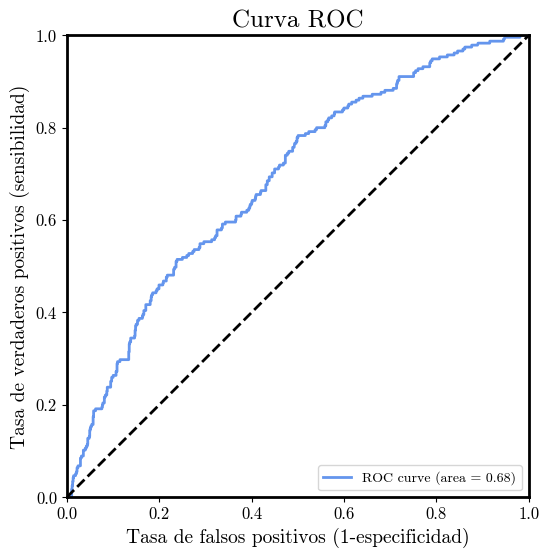

Predicción sobre derivación


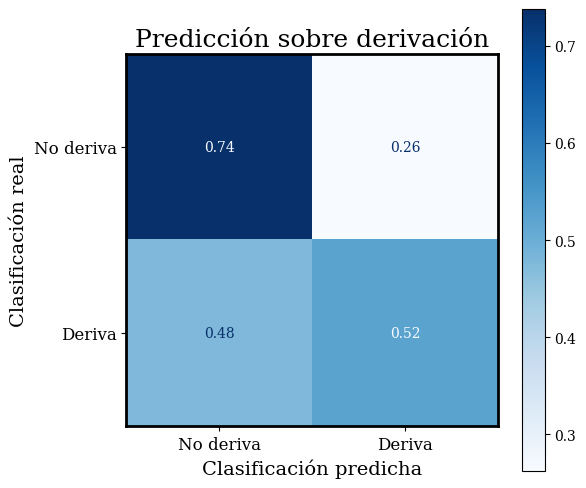

In [ ]:
import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.tree import DecisionTreeClassifier, plot_tree

rcParams['font.family'] = 'cmr10'
keras.utils.set_random_seed(42)

bernoulli_nb_classifier = BernoulliNB()

param_grid = {'alpha': [0.1, 0.5, 1.0], 'fit_prior': [True, False], 'class_prior': [None, [0.5, 0.5]]}

weighted_f1_scorer = make_scorer(f1_score, average='weighted')

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(bernoulli_nb_classifier, param_grid, cv=cv, scoring=weighted_f1_scorer)
grid_search.fit(X_train, y_train)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test)

weighted_f1 = f1_score(y_test, y_pred, average='weighted')
classification_report_str = metrics.classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')
print('Classification Report:')
print(classification_report_str)

# ROC
y_probs = best_classifier.predict_proba(X_test)[:, 1]
fpr_A, tpr_A, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr_A, tpr_A)
roc_auc_A = roc_auc
roc_auc_bernouilli = roc_auc

# Plot ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr_A, tpr_A, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.axis("square")
plt.xlabel("Tasa de falsos positivos (1-especificidad)", fontsize=14)
plt.ylabel("Tasa de verdaderos positivos (sensibilidad)", fontsize=14)
plt.title("Curva ROC", fontsize=18)

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

# Plot matriz de confusión
rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = [6, 6]
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No deriva','Deriva'])
disp.plot(cmap='Blues', values_format='.2f')
disp.ax_.set_title('Predicción sobre derivación', fontsize=18)
disp.ax_.set_xlabel('Clasificación predicha', fontsize=14)
disp.ax_.set_ylabel('Clasificación real', fontsize=14)
print('Predicción sobre derivación')

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# 3) Complement Naive bayes

Best Parameters: {'alpha': 0.5, 'class_prior': None, 'fit_prior': True}
Weighted F1-score with Best Parameters: 0.6492676141257442
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.60      0.71       947
           1       0.29      0.66      0.40       235

    accuracy                           0.61      1182
   macro avg       0.58      0.63      0.56      1182
weighted avg       0.76      0.61      0.65      1182



<ipython-input-38-4c2641bcaa23>:48: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(fpr_B, tpr_B, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))


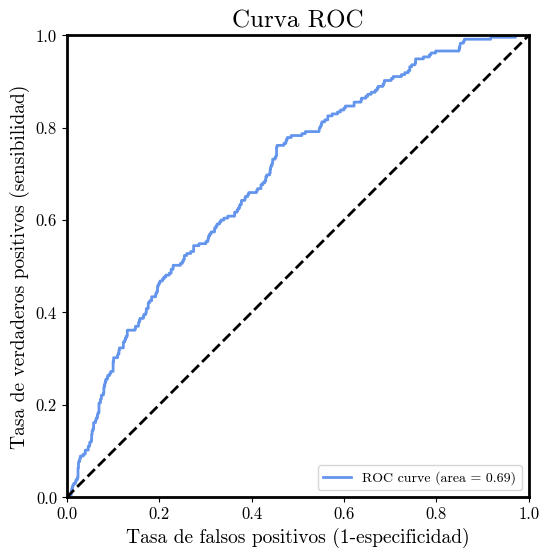

Predicción sobre derivación


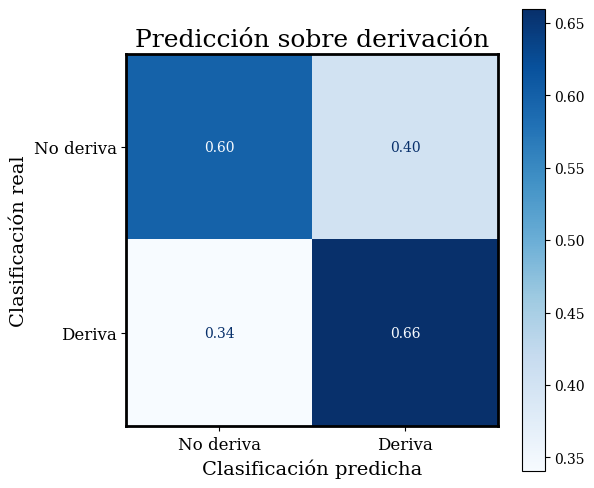

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, confusion_matrix
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.family']='cmr10'

keras.utils.set_random_seed(42)

class_weights = len(y_train) / (2 * np.bincount(y_train))

complement_nb_classifier = ComplementNB(class_prior=class_weights)

param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2], 'fit_prior': [True, False], 'class_prior': [None, [0.5, 0.5]]}

weighted_f1_scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(complement_nb_classifier, param_grid, cv=3, scoring=weighted_f1_scorer)
grid_search.fit(X_train, y_train)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test)

weighted_f1 = f1_score(y_test, y_pred, average='weighted')
classification_report_str = metrics.classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')
print('Classification Report:')
print(classification_report_str)

# ROC
y_probs = best_classifier.predict_proba(X_test)[:, 1]
fpr_B, tpr_B, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr_B, tpr_B)

roc_auc_B = roc_auc

roc_auc_complement = roc_auc

# Plot curva ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr_B, tpr_B, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.axis("square")
plt.xlabel("Tasa de falsos positivos (1-especificidad)", fontsize=14)
plt.ylabel("Tasa de verdaderos positivos (sensibilidad)", fontsize=14)
plt.title("Curva ROC", fontsize=18)

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xlim([0,1])
plt.ylim([0,1])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

# Plot matriz de confusión
rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = [6, 6]
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No deriva','Deriva'])
disp.plot(cmap='Blues', values_format='.2f')
disp.ax_.set_title('Predicción sobre derivación', fontsize=18)
disp.ax_.set_xlabel('Clasificación predicha', fontsize=14)
disp.ax_.set_ylabel('Clasificación real', fontsize=14)
print('Predicción sobre derivación')

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [ ]:
# Obtener la importancia de las variables
feature_importance = best_classifier.feature_log_prob_
feature_importance_df = pd.DataFrame(feature_importance.T, columns=['Class 0', 'Class 1'], index=X.columns)
print("Importancia de las variables:")
feature_importance_df.sort_values(by='Class 1',ascending=False)

Importancia de las variables:


,Class 0,Class 1
ar_Técnicas de exposición,10.670280,11.492549
facultad_Recursos humanos,10.670280,11.492549
ar_Contrato conductual o planificación de contingencias,10.670280,11.492549
vic_Victimización indirecta,7.534786,11.492549
vic_Victimización a través de internet,10.670280,10.393937
...,...,...
genero_Mujer,4.137946,4.202939
BDI-II_4,4.207251,4.112917
ar_Ventilación emocional,3.900638,4.026894
estado_civil_solter,3.794015,3.882192


                                                Class 0   Class 1
estado_civil_cas                               7.236293  6.747617
estado_civil_divorci                           7.302984  7.996042
estado_civil_solter                            3.794015  3.882192
estado_civil_viud                             10.670280  8.548110
genero_Hombre                                  4.815208  4.884549
genero_Mujer                                   4.137946  4.202939
genero_No binario                              8.473056  8.196712
facultad_Bellas Artes                          6.592743  7.123101
facultad_Ciencias Biológicas                   6.778460  7.731349
facultad_Ciencias Económicas y Empresariales   6.778460  7.123101


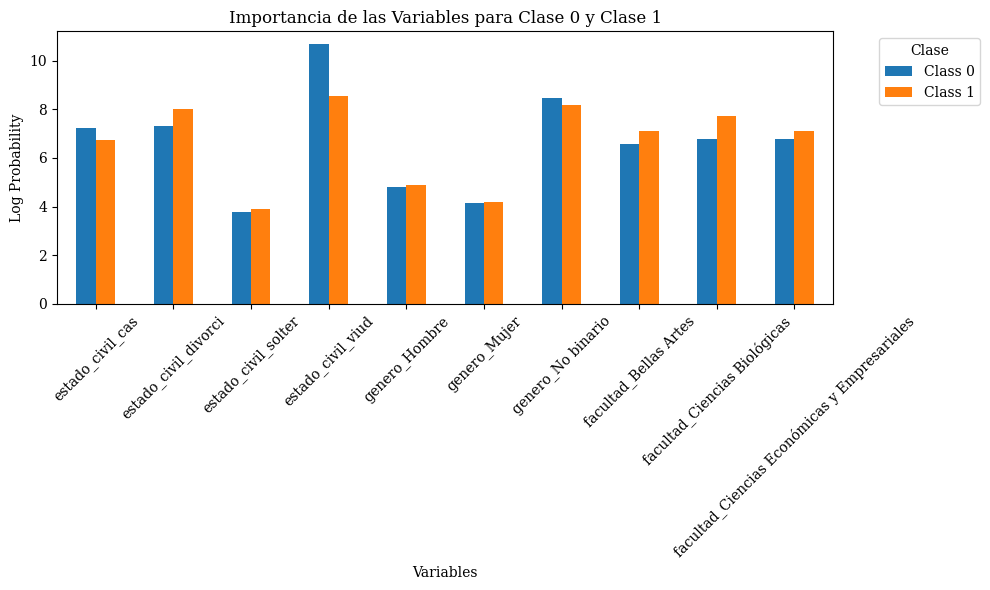

In [ ]:
# 10 características más importantes
top_10_importances = feature_importance_df.head(10)

# Plot importancia de las variables
plt.figure(figsize=(10, 6))
top_10_importances.plot(kind='bar', rot=45, ax=plt.gca())
plt.title('Importancia de las Variables para Clase 0 y Clase 1')
plt.ylabel('Log Probability')
plt.xlabel('Variables')
plt.legend(title='Clase', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4) KNearestCentroid

Best Parameters: {'shrink_threshold': None}
Weighted F1-score with Best Parameters: 0.40402674434434227
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.28      0.42       947
           1       0.22      0.83      0.35       235

    accuracy                           0.38      1182
   macro avg       0.54      0.55      0.38      1182
weighted avg       0.74      0.38      0.40      1182

Predicción sobre derivación


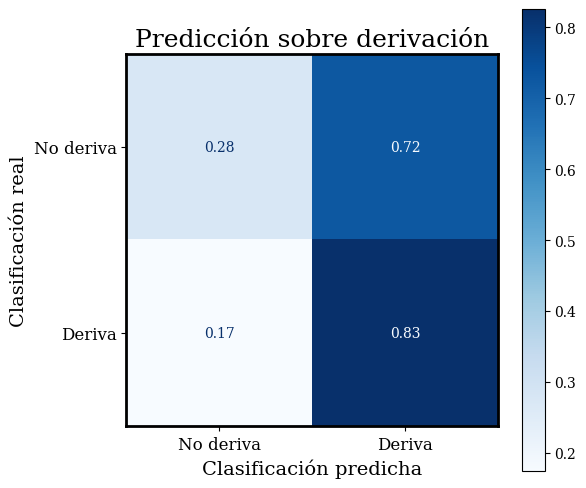

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'cmr10'

keras.utils.set_random_seed(42)

knearest_centroid_classifier = NearestCentroid()
param_grid = {'shrink_threshold': [None, 0.1, 0.5, 1.0]}
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# GridSearchCV
grid_search = GridSearchCV(knearest_centroid_classifier, param_grid, cv=3, scoring=weighted_f1_scorer)
grid_search.fit(X_train, y_train)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test)

weighted_f1 = f1_score(y_test, y_pred, average='weighted')
classification_report_str = metrics.classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')
print('Classification Report:')
print(classification_report_str)

# Plot matriz de confusión
rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = [6, 6]
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No deriva','Deriva'])
disp.plot(cmap='Blues', values_format='.2f')
disp.ax_.set_title('Predicción sobre derivación', fontsize=18)
disp.ax_.set_xlabel('Clasificación predicha', fontsize=14)
disp.ax_.set_ylabel('Clasificación real', fontsize=14)
print('Predicción sobre derivación')

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# 5) Support Vector Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'cmr10'

keras.utils.set_random_seed(42)


svc_classifier = SVC(probability=True)

# Hiperparámetros
param_grid = {'C': [0.1, 1, 10, 15, 20], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}

weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# GridSearchCV
grid_search = GridSearchCV(svc_classifier, param_grid, cv=3, scoring=weighted_f1_scorer)
grid_search.fit(X_train, y_train)
best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test)

weighted_f1 = f1_score(y_test, y_pred, average='weighted')
classification_report_str = metrics.classification_report(y_test, y_pred)

# Hiperparámetros óptimos
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')
print('Classification Report:')
print(classification_report_str)

# Curva ROC
y_probs = best_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot curva ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.axis("square")
plt.xlabel("Tasa de falsos positivos (1-especificidad)", fontsize=14)
plt.ylabel("Tasa de verdaderos positivos (sensibilidad)", fontsize=14)
plt.title("Curva ROC", fontsize=18)

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

# Plot matriz de confusión
rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = [6, 6]
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No deriva','Deriva'])
disp.plot(cmap='Blues', values_format='.2f')
disp.ax_.set_title('Predicción sobre derivación', fontsize=18)
disp.ax_.set_xlabel('Clasificación predicha', fontsize=14)
disp.ax_.set_ylabel('Clasificación real', fontsize=14)
print('Predicción sobre derivación')

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# SGD classifier

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

Best Parameters: {'alpha': 0.001, 'learning_rate': 'optimal', 'penalty': 'l1'}
Weighted F1-score with Best Parameters: 0.7476773556001483
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       947
           1       0.36      0.33      0.35       235

    accuracy                           0.75      1182
   macro avg       0.60      0.59      0.60      1182
weighted avg       0.74      0.75      0.75      1182



<ipython-input-117-e34cde8c82c5>:52: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(fpr, tpr, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))


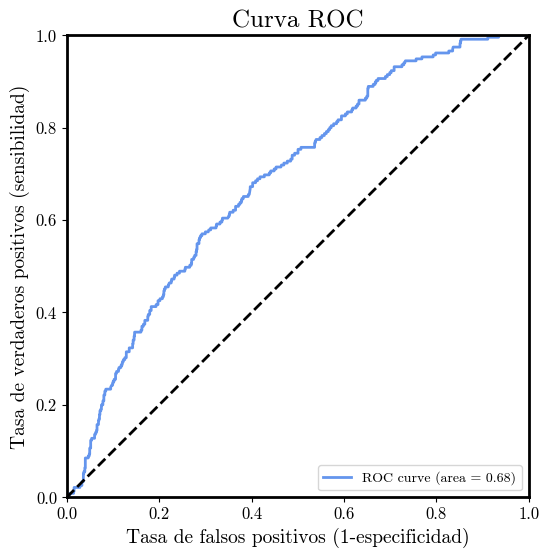

Predicción sobre derivación


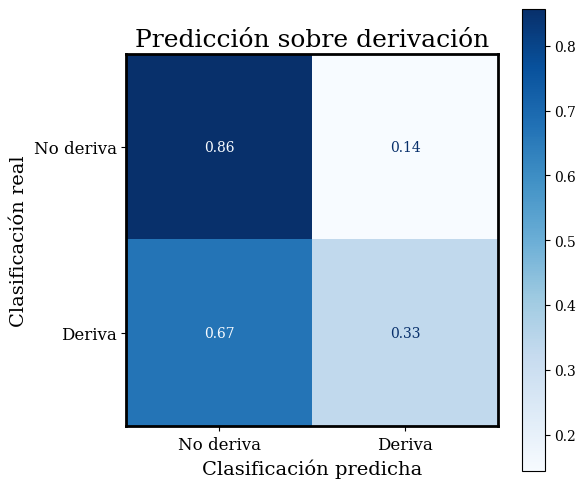

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'cmr10'

keras.utils.set_random_seed(42)

sgd_classifier = SGDClassifier(loss='log', max_iter=1000, random_state=42)

# Hiperparámetros a ajustar
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
              'penalty': ['l1', 'l2'],
              'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']}

weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# GridSearchCV
grid_search = GridSearchCV(sgd_classifier, param_grid, cv=3, scoring=weighted_f1_scorer)

grid_search.fit(X_train, y_train)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test)

# F1
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
classification_report_str = metrics.classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')
print('Classification Report:')
print(classification_report_str)

# Plot curva ROC
y_probs = best_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.axis("square")
plt.xlabel("Tasa de falsos positivos (1-especificidad)", fontsize=14)
plt.ylabel("Tasa de verdaderos positivos (sensibilidad)", fontsize=14)
plt.title("Curva ROC", fontsize=18)

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

# Plot matriz de confusión
rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = [6, 6]
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No deriva','Deriva'])
disp.plot(cmap='Blues', values_format='.2f')
disp.ax_.set_title('Predicción sobre derivación', fontsize=18)
disp.ax_.set_xlabel('Clasificación predicha', fontsize=14)
disp.ax_.set_ylabel('Clasificación real', fontsize=14)
print('Predicción sobre derivación')

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## Regresión logística binaria

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'cmr10'

keras.utils.set_random_seed(42)

logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

# Hiperparámetros a ajustar
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga']}

# F1 weighted
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# GridSearchCV
grid_search = GridSearchCV(logistic_regression, param_grid, cv=3, scoring=weighted_f1_scorer)
grid_search.fit(X_train, y_train)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test)

# F1-score ponderado
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
classification_report_str = metrics.classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')
print('Classification Report:')
print(classification_report_str)

# Plot curva ROC
y_probs = best_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.axis("square")
plt.xlabel("Tasa de falsos positivos (1-especificidad)", fontsize=14)
plt.ylabel("Tasa de verdaderos positivos (sensibilidad)", fontsize=14)
plt.title("Curva ROC", fontsize=18)

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

# Plot matriz de confusión
rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = [6, 6]
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No deriva','Deriva'])
disp.plot(cmap='Blues', values_format='.2f')
disp.ax_.set_title('Predicción sobre derivación', fontsize=18)
disp.ax_.set_xlabel('Clasificación predicha', fontsize=14)
disp.ax_.set_ylabel('Clasificación real', fontsize=14)
print('Predicción sobre derivación')

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## Regresión polinómica binomial

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

Best Parameters: {'alpha': 0.0001, 'learning_rate': 'optimal', 'penalty': 'l1'}
Weighted F1-score with Best Parameters: 0.28749185622734535
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.16      0.27       947
           1       0.22      0.97      0.36       235

    accuracy                           0.32      1182
   macro avg       0.59      0.57      0.32      1182
weighted avg       0.81      0.32      0.29      1182



<ipython-input-35-1d7a885a38b7>:58: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(fpr, tpr, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))


(0.0, 1.0)

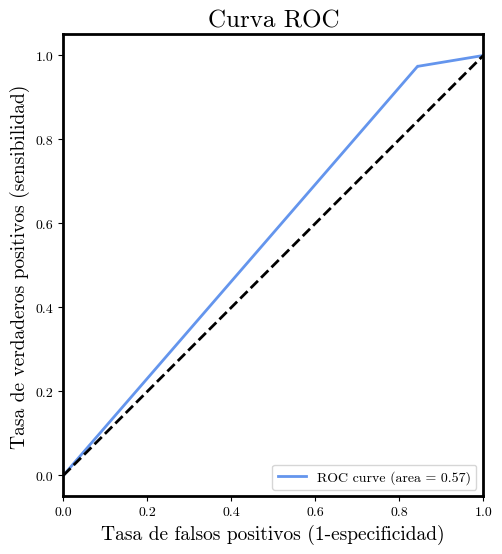

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'cmr10'

keras.utils.set_random_seed(42)

degree = 2
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

sgd_classifier = SGDClassifier(loss='log', max_iter=1000, random_state=42)

param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
              'penalty': ['l1', 'l2'],
              'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']}

weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# GridSearchCV
grid_search = GridSearchCV(sgd_classifier, param_grid, cv=3, scoring=weighted_f1_scorer)

grid_search.fit(X_train_poly, y_train)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test_poly)

weighted_f1 = f1_score(y_test, y_pred, average='weighted')
classification_report_str = metrics.classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')
print('Classification Report:')
print(classification_report_str)

# Plot curva ROC
y_probs = best_classifier.predict_proba(X_test_poly)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.axis("square")
plt.xlabel("Tasa de falsos positivos (1-especificidad)", fontsize=14)
plt.ylabel("Tasa de verdaderos positivos (sensibilidad)", fontsize=14)
plt.title("Curva ROC", fontsize=18)

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xlim([0, 1])

# ENSEMBLES:

## 1) ÁRBOL DE DECISIÓN CON RANDOM FOREST

In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold

keras.utils.set_random_seed(42)

##################################

cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Primera aproximación, random forest con parámetros por defecto
rf1 = RandomForestClassifier(class_weight='balanced',n_jobs=-1)
scores = cross_validate(rf1, X, y, cv=cv, scoring=('accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'))
scores

{'fit_time': array([0.55078316, 0.53604102, 0.58481622]),
 'score_time': array([0.0576539 , 0.05385041, 0.070719  ]),
 'test_accuracy': array([0.8173516 , 0.82025895, 0.81111957]),
 'test_precision_weighted': array([0.78372192, 0.78622126, 0.77501007]),
 'test_recall_weighted': array([0.8173516 , 0.82025895, 0.81111957]),
 'test_f1_weighted': array([0.77044549, 0.77232699, 0.76130195])}

In [ ]:
#GridSearch haciendo búsqueda completa, ya que hay tiempo de cómputo
from sklearn.model_selection import GridSearchCV

keras.utils.set_random_seed(42)

parameters = {
  'n_estimators': np.arange(5,51,10),
  'max_depth': np.arange(1,30,5),
  'criterion': ('gini', 'entropy', 'log_loss')
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
gs = GridSearchCV(rf, parameters, scoring='roc_auc', verbose=1, n_jobs=-1, cv=3) #return_train_score=True
gs.fit(X, y)

import pandas as pd
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')


Fitting 3 folds for each of 90 candidates, totalling 270 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
33,0.133890,0.035000,0.018004,0.008245,entropy,1,35,"{'criterion': 'entropy', 'max_depth': 1, 'n_es...",0.730395,0.688238,0.545257,0.654630,0.079230,1
63,0.075718,0.001456,0.009700,0.000114,log_loss,1,35,"{'criterion': 'log_loss', 'max_depth': 1, 'n_e...",0.730395,0.688238,0.545257,0.654630,0.079230,1
3,0.080267,0.001345,0.010616,0.001014,gini,1,35,"{'criterion': 'gini', 'max_depth': 1, 'n_estim...",0.730395,0.675581,0.542164,0.649380,0.079047,3
34,0.148894,0.032758,0.020727,0.001223,entropy,1,45,"{'criterion': 'entropy', 'max_depth': 1, 'n_es...",0.733317,0.675476,0.532324,0.647039,0.084483,4
64,0.093854,0.002146,0.011295,0.000184,log_loss,1,45,"{'criterion': 'log_loss', 'max_depth': 1, 'n_e...",0.733317,0.675476,0.532324,0.647039,0.084483,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.027291,0.000071,0.005732,0.000087,log_loss,21,5,"{'criterion': 'log_loss', 'max_depth': 21, 'n_...",0.647202,0.547995,0.567707,0.587635,0.042883,86
50,0.028003,0.001476,0.005674,0.000456,entropy,21,5,"{'criterion': 'entropy', 'max_depth': 21, 'n_e...",0.647202,0.547995,0.567707,0.587635,0.042883,86
25,0.029938,0.002694,0.006135,0.000040,gini,26,5,"{'criterion': 'gini', 'max_depth': 26, 'n_esti...",0.623834,0.550933,0.548979,0.574582,0.034835,88
55,0.029950,0.001086,0.005985,0.000175,entropy,26,5,"{'criterion': 'entropy', 'max_depth': 26, 'n_e...",0.626246,0.545609,0.546078,0.572644,0.037902,89


Predicción sobre derivación


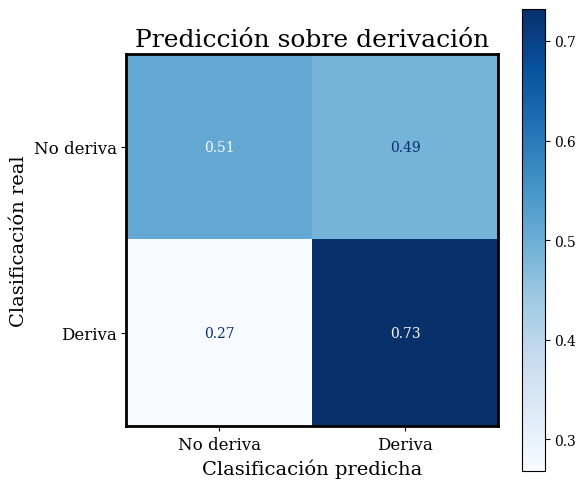

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import rcParams
rcParams['font.family']='DejaVu Serif'

keras.utils.set_random_seed(42)

rf = RandomForestClassifier(class_weight='balanced', n_estimators=35, criterion='entropy',max_depth=1, n_jobs=-1, random_state=42)

rf.fit(X_train, y_train)

plt.rcParams["figure.figsize"] = [6, 6]
disp = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues', normalize='true',display_labels=['No deriva','Deriva'])
disp.ax_.set_title('Predicción sobre derivación', fontsize=18)

disp.ax_.set_xlabel('Clasificación predicha', fontsize=14)
disp.ax_.set_ylabel('Clasificación real', fontsize=14);
print('Predicción sobre derivación')

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)

In [ ]:
from sklearn.metrics import classification_report
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.51      0.65       947
           1       0.27      0.73      0.40       235

    accuracy                           0.56      1182
   macro avg       0.58      0.62      0.52      1182
weighted avg       0.76      0.56      0.60      1182



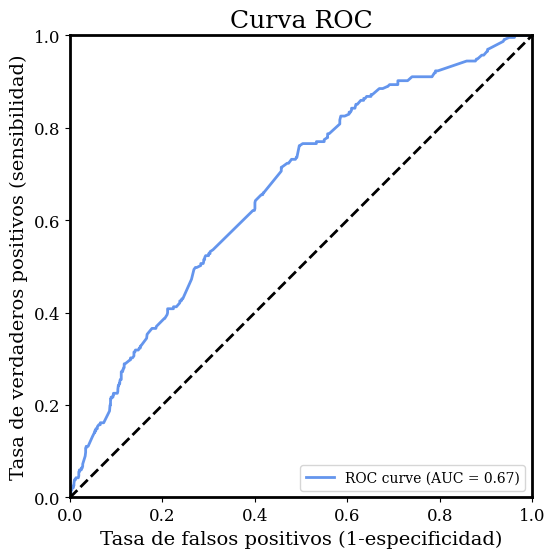

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Curva ROC
y_probs = rf.predict_proba(X_test)[:, 1]
fpr_C, tpr_C, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr_C, tpr_C)

roc_auc_C = roc_auc
roc_auc_complement = roc_auc_score(y_test, y_probs)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr_C, tpr_C, color='cornflowerblue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.axis("square")
plt.xlabel("Tasa de falsos positivos (1-especificidad)", fontsize=14)
plt.ylabel("Tasa de verdaderos positivos (sensibilidad)", fontsize=14)
plt.title("Curva ROC", fontsize=18)

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()


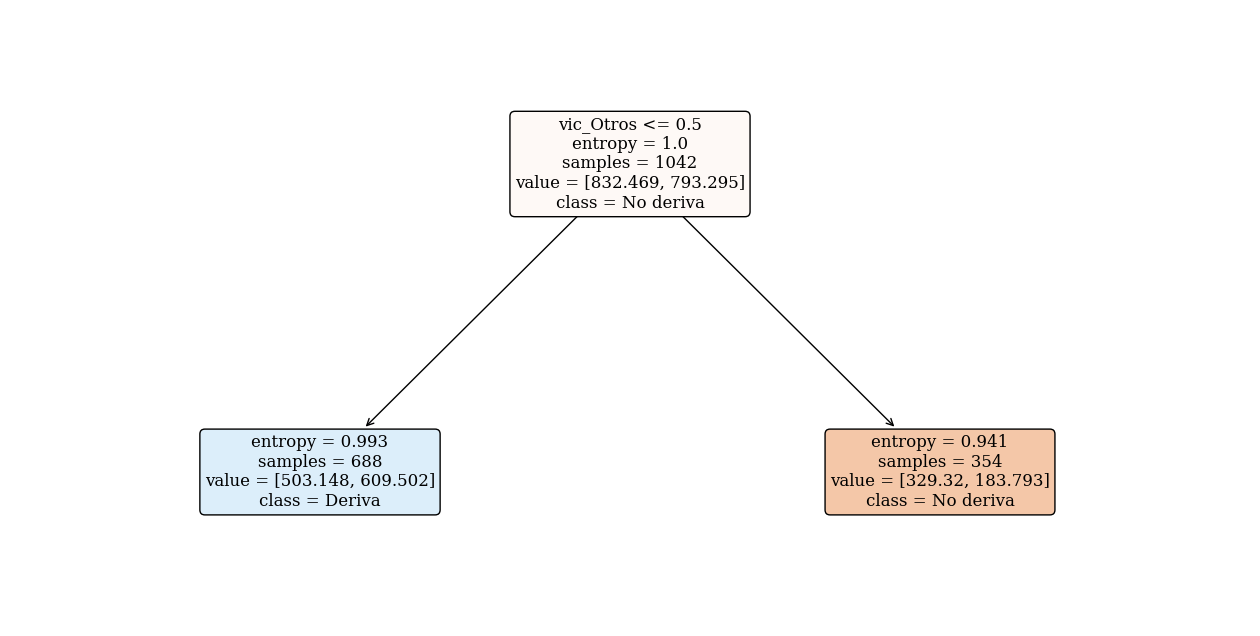

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt

#tree_rules = export_text(rf.estimators_[0], feature_names=DATA.iloc[:,:-1].columns.to_list())
#print(tree_rules)

plt.figure(figsize=(16, 8))
_ = plot_tree(rf.estimators_[0], feature_names=X.columns.to_list(), class_names=['No deriva','Deriva'], filled=True, rounded=True,max_depth=3,fontsize=12)
plt.show()

                                     Feature  Importance
103         vul_Situación económica precaria    0.114286
118                                vic_Otros    0.085714
109                                vul_Otros    0.085714
43                                  PHQ2_2_3    0.085714
62                                      edad    0.057143
78                   mc_Problemas familiares    0.057143
63                           paciente_actual    0.057143
117  vic_No se ha identificado victimización    0.057143
85                    mc_Violencia de género    0.028571
48                                  BDI-II_3    0.028571


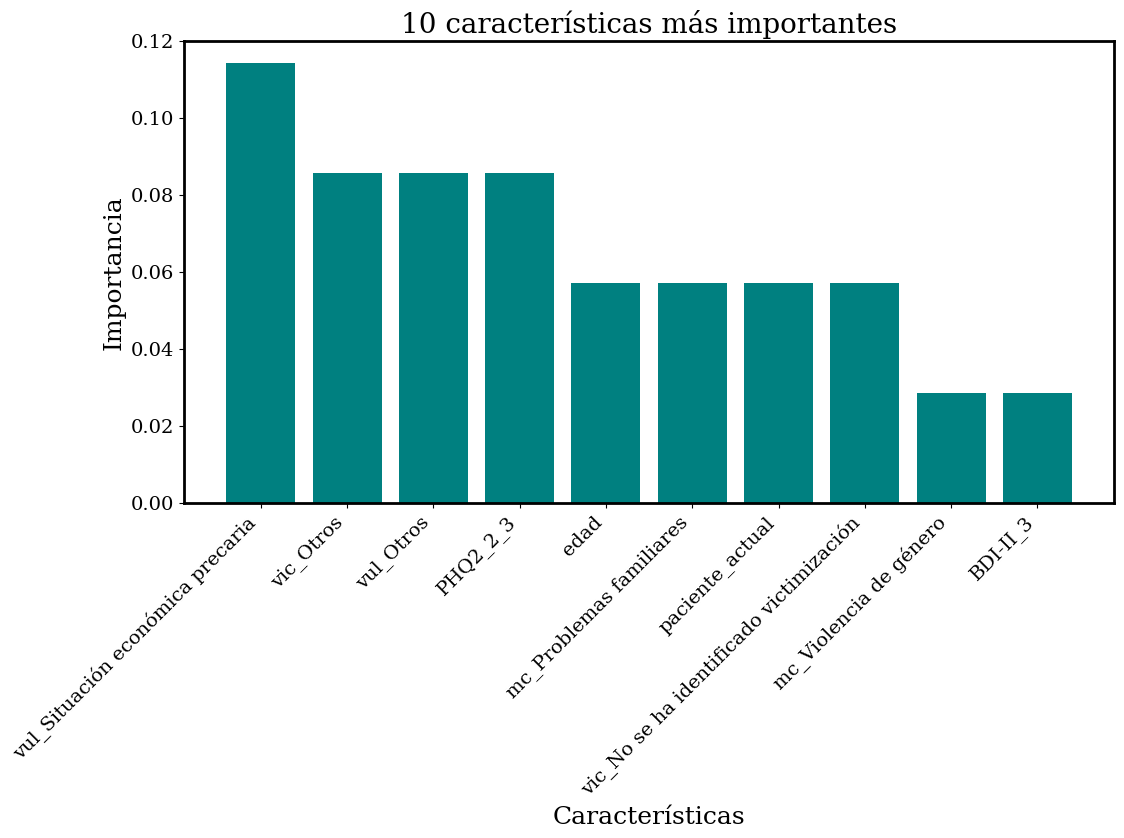

In [ ]:
# Obtener las feature importances del modelo entrenado
feature_importances = rf.feature_importances_
feature_names = X.columns
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
# Seleccionar las 10 características más importantes
top_10_importances = importances_df.head(10)
print(top_10_importances)

# Crear un gráfico de barras para visualizar las importancias de las 10 features más importantes
plt.figure(figsize=(12, 6))
plt.bar(top_10_importances['Feature'], top_10_importances['Importance'], color='teal')
plt.xlabel('Características',fontsize=18)
plt.ylabel('Importancia',fontsize=18)
plt.title('10 características más importantes',fontsize=20)
plt.xticks(rotation=45, ha='right')


# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

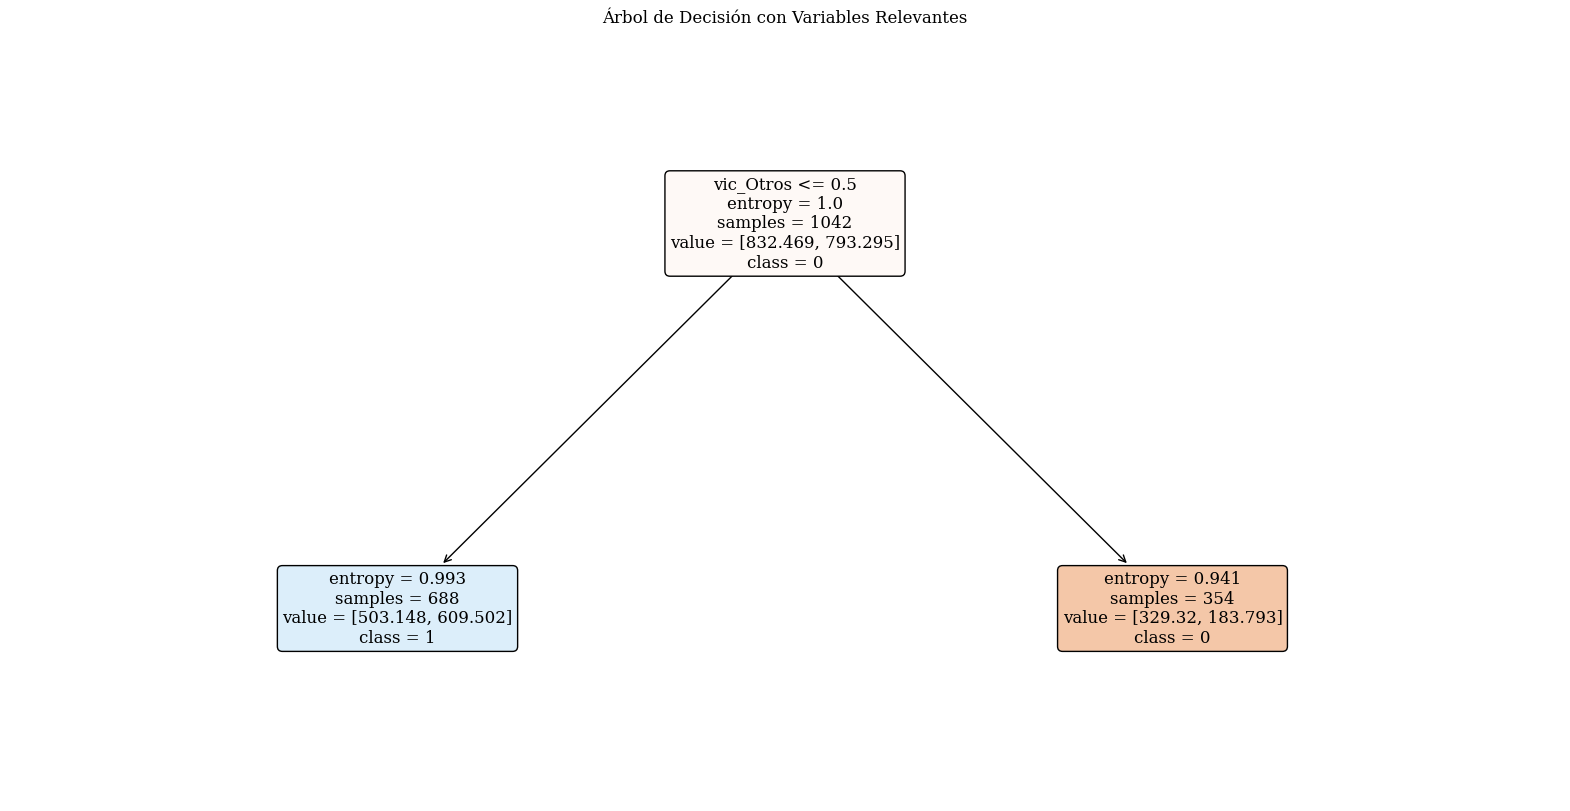

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

# Extraer el primer árbol
tree_estimator = rf.estimators_[0]

plt.figure(figsize=(20, 10))
class_names = list(map(str, rf.classes_))
plot_tree(tree_estimator, feature_names=feature_names, class_names=class_names,max_depth=3, filled=True, rounded=True,fontsize=12)
plt.title('Árbol de Decisión con Variables Relevantes')
plt.show()

## 2) Gradient boosting:

### - XGBoost

Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}
Weighted F1-score with Best Parameters: 0.7655524663369369
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       947
           1       0.41      0.37      0.39       235

    accuracy                           0.77      1182
   macro avg       0.63      0.62      0.63      1182
weighted avg       0.76      0.77      0.77      1182



<ipython-input-131-b1f05c40e040>:54: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(fpr, tpr, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))


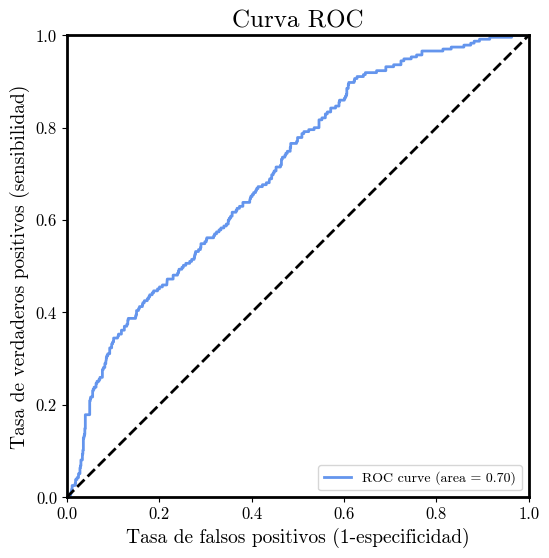

Predicción sobre derivación


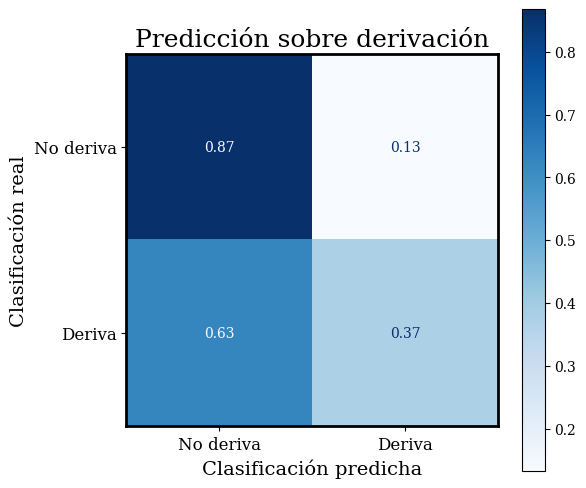

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'cmr10'
rcParams['font.family']='DejaVu Serif'
keras.utils.set_random_seed(42)

########

xgb_classifier = XGBClassifier()
param_grid = {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 5]}
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# GridSearchCV
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring=weighted_f1_scorer)
grid_search.fit(X_train, y_train)
best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test)

weighted_f1 = f1_score(y_test, y_pred, average='weighted')
classification_report_str = metrics.classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')
print('Classification Report:')
print(classification_report_str)

# Plot curva ROC
y_probs = best_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.axis("square")
plt.xlabel("Tasa de falsos positivos (1-especificidad)", fontsize=14)
plt.ylabel("Tasa de verdaderos positivos (sensibilidad)", fontsize=14)
plt.title("Curva ROC", fontsize=18)

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

# Plot matriz de confusión
rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = [6, 6]
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No deriva','Deriva'])
disp.plot(cmap='Blues', values_format='.2f')
disp.ax_.set_title('Predicción sobre derivación', fontsize=18)
disp.ax_.set_xlabel('Clasificación predicha', fontsize=14)
disp.ax_.set_ylabel('Clasificación real', fontsize=14)
print('Predicción sobre derivación')

# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

### - LightGBM

Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

<ipython-input-132-64c014e8b217>:61: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(fpr, tpr, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))


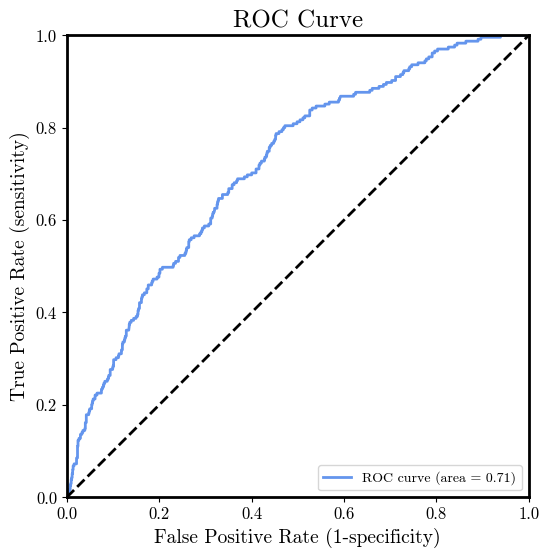

Predicción sobre derivación


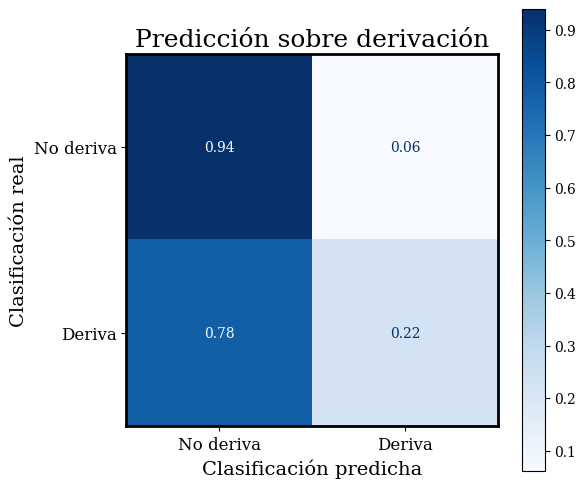

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import re

rcParams['font.family'] = 'cmr10'

keras.utils.set_random_seed(42)

X.columns = [re.sub('[^A-Za-z0-9_]+', '', col) for col in X.columns]

lgbm_classifier = LGBMClassifier()

param_grid = {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 5]}

weighted_f1_scorer = make_scorer(f1_score, average='weighted')

grid_search = GridSearchCV(lgbm_classifier, param_grid, cv=3, scoring=weighted_f1_scorer)
grid_search.fit(X_train, y_train)
best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test)

weighted_f1 = f1_score(y_test, y_pred, average='weighted')
classification_report_str = metrics.classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')
print('Classification Report:')
print(classification_report_str)

y_probs = best_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.axis("square")
plt.xlabel("False Positive Rate (1-specificity)", fontsize=14)
plt.ylabel("True Positive Rate (sensitivity)", fontsize=14)
plt.title("ROC Curve", fontsize=18)

plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

# Plot matriz de confusión
rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = [6, 6]
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No deriva','Deriva'])
disp.plot(cmap='Blues', values_format='.2f')
disp.ax_.set_title('Predicción sobre derivación', fontsize=18)
disp.ax_.set_xlabel('Clasificación predicha', fontsize=14)
disp.ax_.set_ylabel('Clasificación real', fontsize=14)
print('Predicción sobre derivación')


plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# Red neuronal

Epoch 1/500
82/82 [==============================] - 1s 4ms/step - loss: 1.2712 - accuracy: 0.5738 - val_loss: 1.3462 - val_accuracy: 0.6396
Epoch 2/500
82/82 [==============================] - 0s 2ms/step - loss: 0.9964 - accuracy: 0.5573 - val_loss: 1.2362 - val_accuracy: 0.5719
Epoch 3/500
82/82 [==============================] - 0s 2ms/step - loss: 0.8544 - accuracy: 0.5433 - val_loss: 1.1466 - val_accuracy: 0.5474
Epoch 4/500
82/82 [==============================] - 0s 2ms/step - loss: 0.7510 - accuracy: 0.5232 - val_loss: 1.0823 - val_accuracy: 0.4670
Epoch 5/500
82/82 [==============================] - 0s 2ms/step - loss: 0.6556 - accuracy: 0.5293 - val_loss: 1.0119 - val_accuracy: 0.4772
Epoch 6/500
82/82 [==============================] - 0s 2ms/step - loss: 0.5906 - accuracy: 0.5140 - val_loss: 0.9572 - val_accuracy: 0.4662
Epoch 7/500
82/82 [==============================] - 0s 2ms/step - loss: 0.5338 - accuracy: 0.5134 - val_loss: 0.9103 - val_accuracy: 0.4628
Epoch 8/500
8

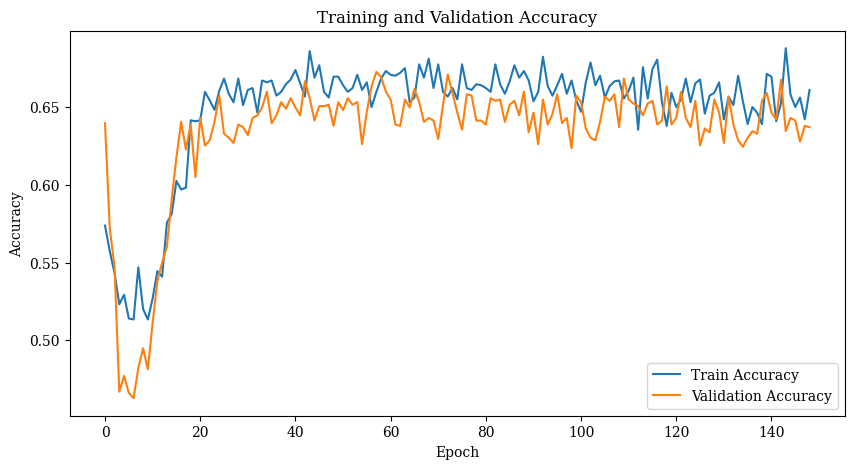

In [ ]:
import pandas as pd
import keras
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

keras.utils.set_random_seed(42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential()
model.add(Dense(50, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.8))  # Agregar Dropout para controlar el sobreajuste
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))  # Agregar Dropout para controlar el sobreajuste
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

optimizer = Adam(learning_rate=0.0008)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = {class_label: total_samples / (len(class_counts) * count) for class_label, count in enumerate(class_counts)}

sum_weights = sum(class_weights.values())
class_weights_normalized = {class_label: weight / sum_weights for class_label, weight in class_weights.items()}

history = model.fit(X_train_scaled, y_train, epochs=500, batch_size=20, validation_data=(X_test_scaled, y_test),
           class_weight=class_weights_normalized,callbacks=[early_stopping], verbose=1) #batch_size=32


y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)


accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_rep)

# Plot curva de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

37/37 [==============================] - 0s 964us/step


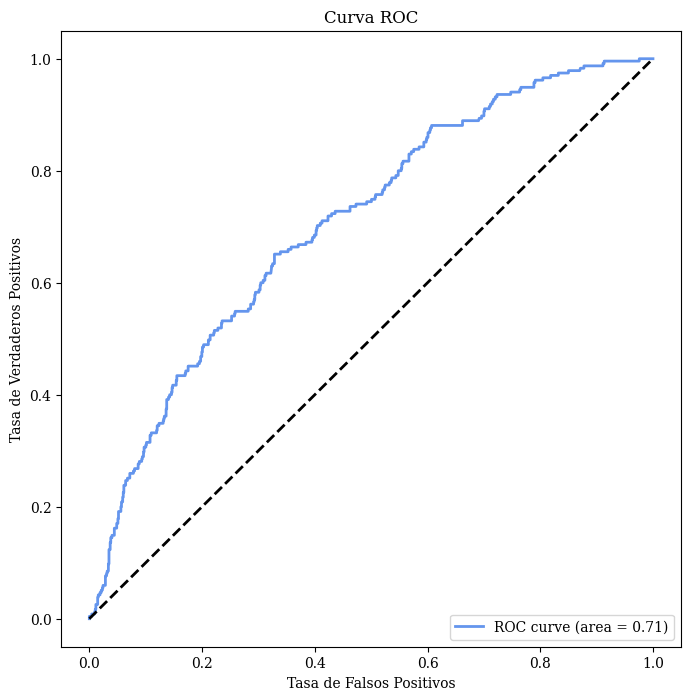

In [ ]:
y_probs = model.predict(X_test_scaled)

fpr_D, tpr_D, thresholds = roc_curve(y_test, y_probs)

roc_auc_D = auc(fpr_D, tpr_D)

# Plot curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr_D, tpr_D, color='cornflowerblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_D))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# PLOT CURVAS ROC MEJORES MODELOS

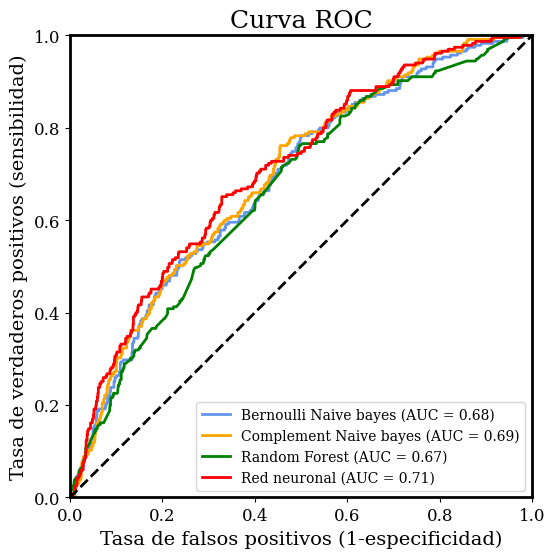

In [ ]:
plt.figure(figsize=(6, 6))

# Curvas para otros modelos
plt.plot(fpr_A, tpr_A, color='cornflowerblue', lw=2, label='Bernoulli Naive bayes (AUC = {:.2f})'.format(roc_auc_A))
plt.plot(fpr_B, tpr_B, color='orange', lw=2, label='Complement Naive bayes (AUC = {:.2f})'.format(roc_auc_B))
plt.plot(fpr_C, tpr_C, color='green', lw=2, label='Random Forest (AUC = {:.2f})'.format(roc_auc_C))
plt.plot(fpr_D, tpr_D, color='red', lw=2, label='Red neuronal (AUC = {:.2f})'.format(roc_auc_D))


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.axis("square")
plt.xlabel("Tasa de falsos positivos (1-especificidad)", fontsize=14)
plt.ylabel("Tasa de verdaderos positivos (sensibilidad)", fontsize=14)
plt.title("Curva ROC", fontsize=18)


# Ajustar grosor de ejes y tamaño de letra
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

#plt.savefig('/content/drive/MyDrive/roc_curves.png', bbox_inches='tight')

NEVERGRAD para conocer los mejores hiperparámetros de la red

In [ ]:
pip install nevergrad

In [ ]:
import nevergrad as ng

def create_model(param_0, param_1, param_2, dropout_1, dropout_2, l2_reg):
    model = Sequential()
    model.add(Dense(param_0, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_1))
    model.add(Dense(param_1, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_2))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg)))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_and_evaluate_model(param_0, param_1, param_2, dropout_1, dropout_2, l2_reg):
    model = create_model(param_0, param_1, param_2, dropout_1, dropout_2, l2_reg)

    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

    history = model.fit(X_train_scaled, y_train, epochs=500, batch_size=20, validation_data=(X_test_scaled, y_test),
                        class_weight=class_weights_normalized, callbacks=[early_stopping], verbose=0)

    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    f1 = f1_score(y_test, y_pred)

    print(f'Parameters: param_0={param_0}, param_1={param_1}, param_2={param_2}, dropout_1={dropout_1}, dropout_2={dropout_2}, l2_reg={l2_reg}')

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("----")

    return -f1  # Nevergrad minimiza el objectivo, así que -F1

# Valores a optimizar
parametrization = ng.p.Instrumentation(
    param_0=ng.p.Scalar(lower=32, upper=256),
    param_1=ng.p.Scalar(lower=8, upper=128),
    param_2=ng.p.Scalar(lower=0.01, upper=1.0),
    dropout_1=ng.p.Scalar(lower=0.1, upper=0.9),
    dropout_2=ng.p.Scalar(lower=0.1, upper=0.9),
    l2_reg=ng.p.Scalar(lower=0.0001, upper=0.01)
)

# Optimización
optimizer = ng.optimizers.OnePlusOne(parametrization=parametrization, budget=100)
recommendation = optimizer.minimize(train_and_evaluate_model)

# Hiperparámetros
best_params = recommendation.value
print("Best Hyperparameters:", best_params)

# Entrenamiento final del modelo
best_model = create_model(**best_params)
best_model.fit(X_train_scaled, y_train, epochs=500, batch_size=20, validation_data=(X_test_scaled, y_test),
               class_weight=class_weights_normalized, callbacks=[early_stopping], verbose=1)



37/37 [==============================] - 0s 3ms/step
Parameters: param_0=144.0, param_1=68.0, param_2=0.505, dropout_1=0.5, dropout_2=0.5, l2_reg=0.00505
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       947
           1       0.37      0.51      0.43       235

    accuracy                           0.73      1182
   macro avg       0.62      0.65      0.62      1182
weighted avg       0.77      0.73      0.74      1182

----
37/37 [==============================] - 0s 1ms/step
Parameters: param_0=66.37090863671344, param_1=65.47402517866792, param_2=0.7958523852807362, dropout_1=0.7437908056513998, dropout_2=0.32998460876830055, l2_reg=0.00578448384569777
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       947
           1       0.35      0.56      0.43       235

    accuracy                           0.70      1182
   macro avg   

KeyboardInterrupt: ignored

# COMPLEMENT NAIVE BAYES PARA INTENTAR CLASIFICAR SÓLO CON EL TEXTO DE LA LLAMADA

In [ ]:
!pip install spacy
!python -m spacy download es_core_news_sm

import pandas as pd
import re
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy import stats as st
import keras
# Descargar los recursos necesarios para NLTK
nltk.download('punkt')
nltk.download('stopwords')

keras.utils.set_random_seed(42)

# Cargar el modelo de spaCy
nlp = spacy.load('es_core_news_sm')

# Preprocesamiento de texto
def preprocess_text(text):
    text = re.sub(r"(http[\#a-zA-Z0-9\/:._-]*)"," ", text)
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"\s\w\s", " ", text)
    text = re.sub(r"^\w\s", "", text)
    text = re.sub(r"(\d+)", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"^\s+", "", text)
    text = re.sub(r"\s+$", "", text)
    doc = nlp(text.lower())
    return " ".join([token.lemma_ for token in doc])

DATA_texto =  DATA_texto.loc[DATA.index]

DATA_texto['processed_text'] = DATA_texto['texto_llamada'].apply(preprocess_text)

my_stop_words = ['cib','cup','derivar','derivacion','derivado','derivada','acerca', 'abc', 'tema', 'alguno', 'persona', 'ir', 'llamado', 'situación', 'actividad', 'ahora', 'contar', 'explicar', 'aunque', 'cosa', 'además', 'comentar', 'hablar', 'referir', 'realizar', 'dar', 'decir', 'llamar', 'pensar', 'preguntar', 'llamada', 'usuaria', 'haber', 'tener', 'hacer']


# Vectorización de texto
vectorizer = TfidfVectorizer(max_features=1000, stop_words=stopwords.words('spanish') + my_stop_words)
X = vectorizer.fit_transform(DATA_texto['processed_text'])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, DATA['derivacion_binaria'], test_size=0.3, random_state=42)

# Entrenamiento del modelo Naive Bayes
nb_classifier = ComplementNB()
nb_classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = nb_classifier.predict(X_test)

# Evaluar el rendimiento del modelo
print("Resultados del modelo Naive Bayes:")
print(classification_report(y_test, y_pred))

# Extracción de tópicos con LDA
n_features = 300
tf_vectorizer = CountVectorizer(max_df=0.74, min_df=2,
                                max_features=n_features,
                                stop_words=stopwords.words('spanish') + my_stop_words)
tf = tf_vectorizer.fit_transform(DATA_texto['processed_text']).toarray()

# Al elegir 5 como el número de temas, volvemos a cargar lda con ese número de componentes
lda = LatentDirichletAllocation(n_components=5, max_iter=15,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=1337)
my_sentences_topic = lda.fit_transform(tf)

DATA_todo = pd.merge(DATA_texto, pd.DataFrame(my_sentences_topic, columns=['t1_Problemas_interpersonales', 't2_Problemas_familiares', 't3_Ansiedad', 't4_Seguimiento_Informacion', 't5_Problemas_Academicos']), left_index=True, right_index=True, how='left')
DATA_todo.dropna(inplace=True)

features = tf_vectorizer.get_feature_names_out()
print(features)


2023-12-15 05:21:53.272594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 05:21:53.272673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 05:21:53.275145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 05:21:56.020810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.6.0/es_core_news_sm-3.6.0-py3-none-any.whl (12.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('es_core_new

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Resultados del modelo Naive Bayes:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       947
           1       0.37      0.60      0.46       235

    accuracy                           0.72      1182
   macro avg       0.63      0.67      0.63      1182
weighted avg       0.78      0.72      0.74      1182

['acabar' 'académico' 'aceptar' 'acordar' 'activación' 'actual'
 'actualmente' 'acudir' 'afectar' 'agradable' 'amiga' 'amigo' 'animar'
 'ansiedad' 'anterior' 'aparecer' 'apoyar' 'apoyo' 'asignatura' 'así'
 'ataque' 'atención' 'autocuidado' 'ayuda' 'ayudar' 'año' 'bajo'
 'bastante' 'bien' 'buen' 'buscar' 'cabo' 'cada' 'cambiar' 'cambio'
 'capaz' 'carrera' 'casa' 'caso' 'centrar' 'chica' 'chico' 'cierto' 'cita'
 'clase' 'comenzar' 'comer' 'compañero' 'conducta' 'conocer' 'conseguir'
 'considerar' 'contactar' 'contacto' 'control' 'controlar' 'conversación'
 'correo' 'costar' 'creer' 'cuanto' 'cuenta' 'culpa' 'curso' 'cómo' 'daño'
 'd

<ipython-input-63-bf5a0ea09e02>:24: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.imshow(word_cloud, interpolation='bilinear')


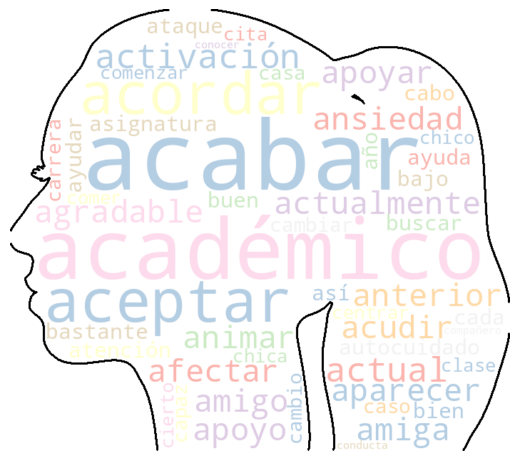

In [ ]:
#pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

#Función para transformar todas las imágenes PNG con fondo transparente a fondo blanco

def transform_white_backgroud(png_path):
    picture = Image.open(png_path).convert("RGBA")
    image = Image.new("RGB", picture.size, "WHITE")
    image.paste(picture, (0, 0), picture)
#    plt.imshow(image)
    mask = np.array(image)
    return mask

mask = transform_white_backgroud("/content/drive/MyDrive/cabeza.png")

corpus = ' '.join(features)

image_colors = ImageColorGenerator(mask) #Generamos los colores de la propia máscara
word_cloud = WordCloud(mask=mask,width=1600, height=800, background_color='white',mode="RGB", contour_width=3, contour_color='black', colormap='Pastel1', max_words=50,random_state=4).generate(corpus)

plt.figure(figsize=(5,5))#, facecolor=None
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## COMPLEMENT NAIVE BAYES SÓLO TEXTO

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, make_scorer, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Descargar los recursos necesarios para NLTK
import nltk
my_stopwords = ['cib', 'cup', 'derivación', 'derivacion', 'derivar', 'derivado', 'derivada']
stop_words = set(stopwords.words('spanish'))  # Puedes ajustar el idioma
# Cargar tus datos, suponiendo que 'DATA' es tu DataFrame
# Asegúrate de tener instaladas las bibliotecas necesarias con: pip install scikit-learn pandas nltk

# Preprocesamiento de texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"\s\w\s", " ", text)
    text = re.sub(r"^\w\s", "", text)
    text = re.sub(r"(\d+)", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"^\s+", "", text)
    text = re.sub(r"\s+$", "", text)
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

DATA['processed_text'] = DATA_texto['texto_llamada'].apply(preprocess_text)

# Vectorización de texto
vectorizer = TfidfVectorizer(max_features=500, stop_words=list(stop_words)+ my_stopwords)
X = vectorizer.fit_transform(DATA['processed_text']).toarray()

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, DATA['derivacion_binaria'], test_size=0.3, random_state=42)

# Entrenamiento del modelo
nb_classifier = ComplementNB()
###################################
alpha_arr = np.linspace(1.1,1.80,5)
param_grid = {'alpha': alpha_arr, 'fit_prior': [True, False], 'class_prior': [None, [0.5, 0.5]]}

weighted_f1_scorer = make_scorer(f1_score, average='macro')

# GridSearchCV
grid_search = GridSearchCV(nb_classifier, param_grid = param_grid, cv=4, scoring=weighted_f1_scorer)
grid_search.fit(X_train, y_train)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test)
###################################

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')

print(classification_report(y_test, y_pred))

rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = [6, 6]
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='.2f')
disp.ax_.set_title('Prediction on Derivation', fontsize=18)
disp.ax_.set_xlabel('Predicted Classification', fontsize=14)
disp.ax_.set_ylabel('True Classification', fontsize=14)
print('Prediction on Derivation')

plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()


In [ ]:
print(X_train.shape)
# Guardamos en una lista las palabras de
list_feature_names = vectorizer.get_feature_names_out().tolist()

(2758, 500)


### BALANCEAMOS DATOS DE TRAIN

In [ ]:
y_train = pd.DataFrame(y_train.to_numpy(),  columns=['derivación'])
X_train = pd.DataFrame(X_train)
X_train_0 = X_train[y_train['derivación'] == 0]
X_train_1 = X_train[y_train['derivación'] == 1]

random_sample_train_0 = X_train_0.sample(n=len(X_train_1), random_state=42)

X_train_balanced = pd.concat([random_sample_train_0, X_train_1])
y_train_balanced = y_train.loc[X_train_balanced.index]

X_train = X_train_balanced
y_train = y_train_balanced

### RANDOM FOREST CLASSIFIER

Best Parameters: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 15}
Weighted F1-score with Best Parameters: 0.583772057576851
              precision    recall  f1-score   support

           0       0.87      0.67      0.76       947
           1       0.31      0.60      0.41       235

    accuracy                           0.66      1182
   macro avg       0.59      0.63      0.58      1182
weighted avg       0.76      0.66      0.69      1182

Prediction on Derivation


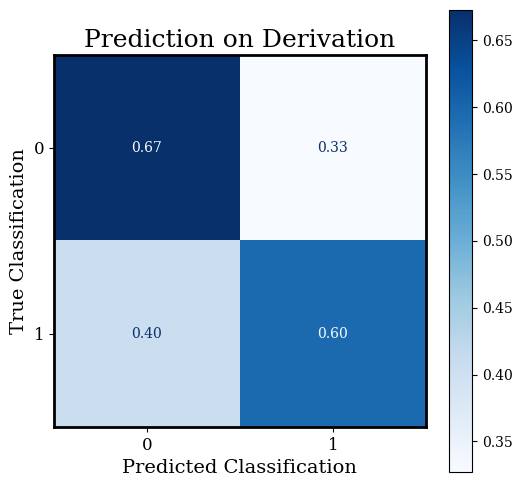

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
random_forest = RandomForestClassifier()
max_depth = list(range(12,28))
n_estimators = list(range(9,19))
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': max_depth, 'n_estimators':n_estimators, 'class_weight': ['balanced', 'balanced_subsample']}

weighted_f1_scorer = make_scorer(f1_score, average='macro')

grid_search = GridSearchCV(random_forest, param_grid, cv=3, scoring=weighted_f1_scorer)

grid_search.fit(X_train, y_train['derivación'].ravel())

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test)

weighted_f1 = f1_score(y_test, y_pred, average='macro')
classification_report_str = metrics.classification_report(y_test, y_pred)
# Imprimir hiperparámetros óptimos y rendimiento del modelo
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')

# Evalúa el rendimiento del modelo
print(classification_report(y_test, y_pred))

rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = [6, 6]
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='.2f')
disp.ax_.set_title('Prediction on Derivation', fontsize=18)
disp.ax_.set_xlabel('Predicted Classification', fontsize=14)
disp.ax_.set_ylabel('True Classification', fontsize=14)
print('Prediction on Derivation')

plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)

### DECISION TREE CLASSIFIER

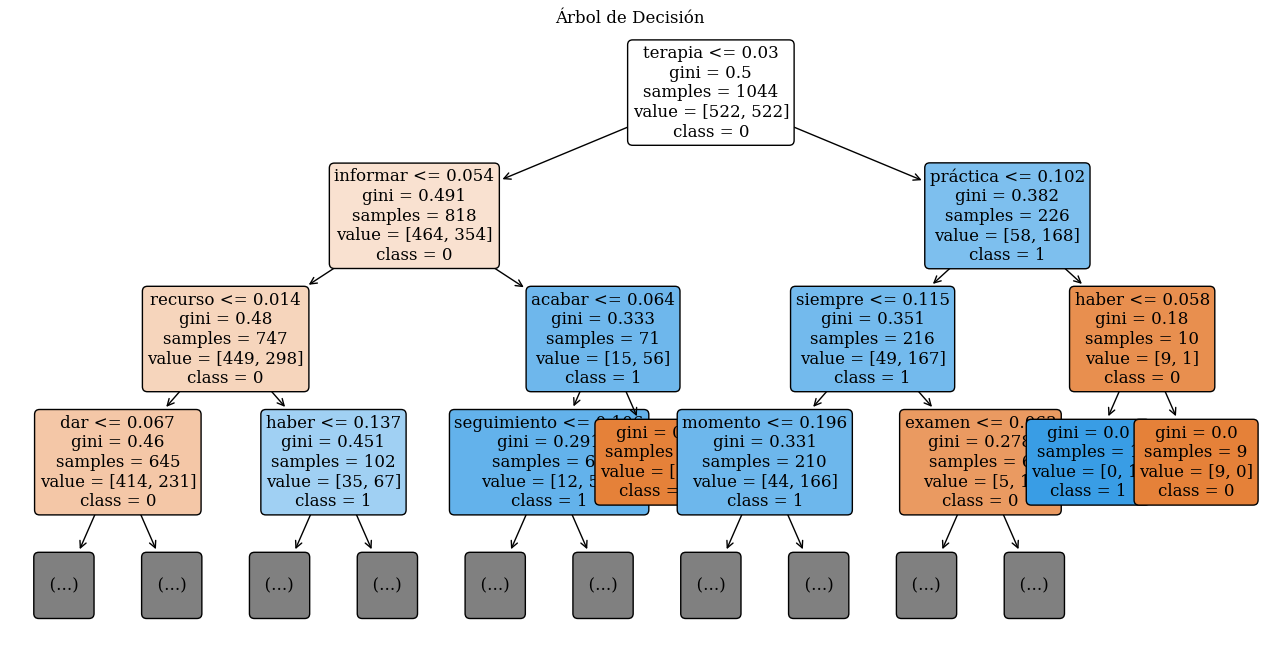

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'splitter': 'best'}
Weighted F1-score with Best Parameters: 0.5677645388345981
              precision    recall  f1-score   support

           0       0.86      0.65      0.74       947
           1       0.29      0.59      0.39       235

    accuracy                           0.64      1182
   macro avg       0.58      0.62      0.57      1182
weighted avg       0.75      0.64      0.67      1182

Prediction on Derivation


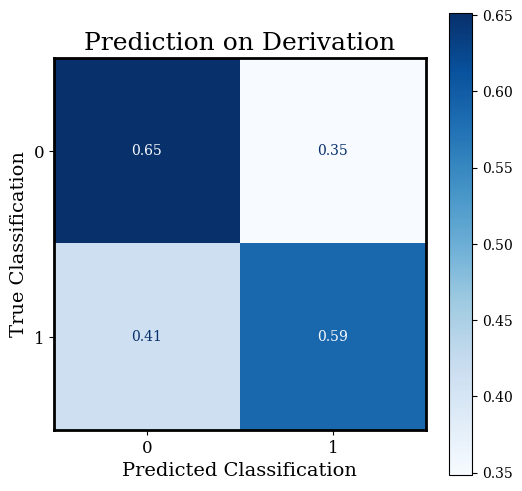

In [ ]:
decision_tree_classifier = DecisionTreeClassifier()
max_depth = list(range(2,11))
param_grid = {'criterion': ['gini'], 'splitter': ['best', 'random'], 'max_depth': max_depth}


weighted_f1_scorer = make_scorer(f1_score, average='weighted')


grid_search = GridSearchCV(decision_tree_classifier, param_grid, cv=4, scoring=weighted_f1_scorer)


grid_search.fit(X_train, y_train)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test)

rcParams['font.family'] = 'DejaVu Serif'
plt.figure(figsize=(16, 8))
plot_tree(best_classifier, filled=True, class_names=['0', '1'], rounded=True, max_depth=3,fontsize=12, feature_names = list_feature_names)
plt.title("Árbol de Decisión", fontsize=12)
plt.show()

weighted_f1 = f1_score(y_test, y_pred, average='macro')
classification_report_str = metrics.classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Weighted F1-score with Best Parameters: {weighted_f1}')

# Evalúa el rendimiento del modelo
print(classification_report(y_test, y_pred))

rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams["figure.figsize"] = [6, 6]
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='.2f')
disp.ax_.set_title('Prediction on Derivation', fontsize=18)
disp.ax_.set_xlabel('Predicted Classification', fontsize=14)
disp.ax_.set_ylabel('True Classification', fontsize=14)
print('Prediction on Derivation')

plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
def plot_train_val(history, metric='loss', y_scale='linear'):
    plt.plot(history.history[metric], label=metric + ' (train)')
    plt.plot(history.history['val_' + metric], label=metric + ' (val)')
    plt.title(f'{metric} ({y_scale}-scale)')
    plt.xlabel('epoch')
    plt.legend(loc="upper right")
    plt.yscale(y_scale)
    plt.show()

# STACKED GENERALIZATION

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tensorflow.keras.regularizers import l2

keras.utils.set_random_seed(42)

rcParams['font.family'] = 'cmr10'

# Naive Bayes

bernoulli_nb_classifier = BernoulliNB(alpha=0.1, class_prior = None, fit_prior = True)

# Complement Naive Bayes
complement_nb_classifier = ComplementNB(alpha = 0.5, class_prior = None, fit_prior = True)

# Random forest
rf_classifier = RandomForestClassifier(class_weight='balanced', n_estimators=35, criterion='entropy',max_depth=1, n_jobs=-1, random_state=42)

# Red neuronal
model = Sequential()
model.add(Dense(50, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.8))  # Agregar Dropout para controlar el sobreajuste
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))  # Agregar Dropout para controlar el sobreajuste
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0008), metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = {class_label: total_samples / (len(class_counts) * count) for class_label, count in enumerate(class_counts)}

sum_weights = sum(class_weights.values())
class_weights_normalized = {class_label: weight / sum_weights for class_label, weight in class_weights.items()}

history = model.fit(X_train_scaled, y_train, epochs=500, batch_size=20, validation_data=(X_test_scaled, y_test),
           class_weight=class_weights_normalized,callbacks=[early_stopping], verbose=1) #batch_size=32


# Stacking Classifier
stacked_classifier = StackingClassifier(
    estimators=[
        ('bernoulli_nb', bernoulli_nb_classifier),
        ('complement_nb', complement_nb_classifier),
        ('rf', rf_classifier),
        ('neural_network', make_pipeline(StandardScaler(), model))
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

stacked_scores = cross_val_score(stacked_classifier, X_train, y_train, cv=5, scoring='f1_weighted')
print(f'Weighted F1-score of Stacked Classifier: {np.mean(stacked_scores)}')

stacked_classifier.fit(X_train, y_train)

stacked_predictions = stacked_classifier.predict(X_test)

stacked_weighted_f1 = f1_score(y_test, stacked_predictions, average='weighted')
stacked_classification_report = classification_report(y_test, stacked_predictions)

print(f'Weighted F1-score of Stacked Classifier on Test Set: {stacked_weighted_f1}')
print('Classification Report for Stacked Classifier:')
print(stacked_classification_report)

Epoch 1/500
49/49 [==============================] - 4s 26ms/step - loss: 1.4019 - accuracy: 0.5088 - val_loss: 1.5733 - val_accuracy: 0.4433
Epoch 2/500
49/49 [==============================] - 0s 8ms/step - loss: 1.2186 - accuracy: 0.5119 - val_loss: 1.4045 - val_accuracy: 0.5254
Epoch 3/500
49/49 [==============================] - 0s 8ms/step - loss: 1.0846 - accuracy: 0.4974 - val_loss: 1.3039 - val_accuracy: 0.5668
Epoch 4/500
49/49 [==============================] - 0s 7ms/step - loss: 0.9844 - accuracy: 0.5139 - val_loss: 1.2244 - val_accuracy: 0.6007
Epoch 5/500
49/49 [==============================] - 0s 5ms/step - loss: 0.8923 - accuracy: 0.5150 - val_loss: 1.1602 - val_accuracy: 0.6235
Epoch 6/500
49/49 [==============================] - 0s 5ms/step - loss: 0.8262 - accuracy: 0.5366 - val_loss: 1.1050 - val_accuracy: 0.6354
Epoch 7/500
49/49 [==============================] - 0s 6ms/step - loss: 0.7805 - accuracy: 0.5222 - val_loss: 1.0553 - val_accuracy: 0.6481
Epoch 8/500


# Ensemble voting

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification

bernoulli_nb = BernoulliNB(alpha=0.1, class_prior=None, fit_prior=True)
complement_nb = ComplementNB(alpha=0.5, class_prior=None, fit_prior=True)
random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=35, criterion='entropy', max_depth=1, n_jobs=-1, random_state=42)
neural_network = MLPClassifier(hidden_layer_sizes=(50, 16), max_iter=1000, random_state=42)
svc = SVC(kernel='linear', C=1.0, random_state=42)  # Puedes ajustar el kernel y C según tus necesidades

# Crear el ensemble de votación
voting_classifier = VotingClassifier(
    estimators=[
        ('bernoulli_nb', bernoulli_nb),
        ('complement_nb', complement_nb),
        ('random_forest', random_forest),
        ('neural_network', neural_network),
        ('svc', svc)
    ],
    voting='hard'
)


voting_classifier.fit(X_train, y_train)


y_pred = voting_classifier.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

# COMPARACIÓN DE MODELOS

{'Bernoulli Naive Bayes': {'precision (1)': 0.33, 'recall (1)': 0.52, 'f1 (1)': 0.41, 'f1-weighted': 0.72}, 'Complement Naive Bayes': {'precision (1)': 0.29, 'recall (1)': 0.66, 'f1 (1)': 0.4, 'f1-weighted': 0.65}, 'Random Forest': {'precision (1)': 0.27, 'recall (1)': 0.73, 'f1 (1)': 0.4, 'f1-weighted': 0.6}, 'Red neuronal': {'precision (1)': 0.35, 'recall (1)': 0.57, 'f1 (1)': 0.44, 'f1-weighted': 0.73}}


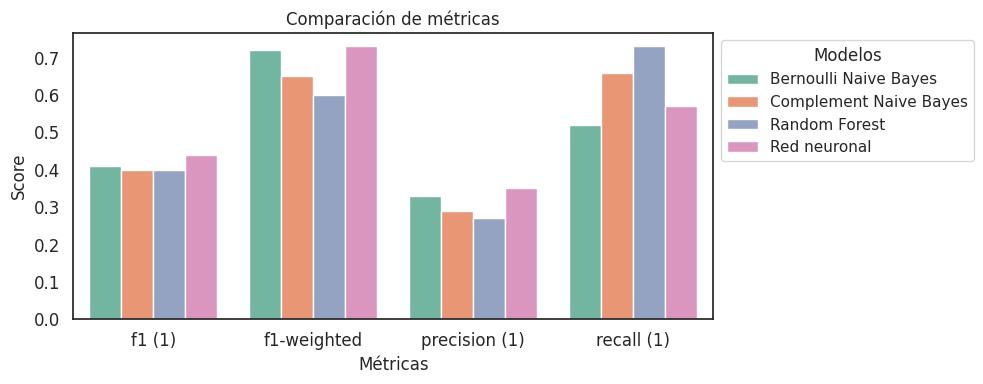

In [ ]:
models = ['Bernoulli Naive Bayes','Complement Naive Bayes','Random Forest','Red neuronal']
# precision_values_0 = [0.86,0.88,0.89,0.87]
# recall_values_0 = [0.74,0.60,0.51,0.74]
# f1_0_values = [0.80,0.71,0.65,0.80]
precision_values_1 = [0.33,0.29,0.27,0.35]
recall_values_1 = [0.52,0.66,0.73,0.57]
f1_1_values = [0.41,0.40,0.40,0.44]
# f1_macro_values = [0.60,0.56,0.52,0.62]
f1_weighted_values = [0.72,0.65,0.60,0.73]

result_dict = {}

for i in range(len(models)):
    result_dict[models[i]] = {
        # 'precision 0': precision_values_0[i],
        # 'recall 0': recall_values_0[i],
        # 'f1 0': f1_0_values[i],
        'precision (1)': precision_values_1[i],
        'recall (1)': recall_values_1[i],
        'f1 (1)': f1_1_values[i],
        # 'f1 macro': f1_macro_values[i],
        'f1-weighted': f1_weighted_values[i]
    }

print(result_dict)

# Create a DataFrame for Seaborn
import pandas as pd

df = pd.DataFrame(result_dict).T.reset_index()
df = pd.melt(df, id_vars='index', var_name='Metric', value_name='Score')
df = df.sort_values(by=['Metric', 'index'])

# Set the Seaborn style
sns.set(style="white")

# Create a grouped bar chart using Seaborn with x='Metric' and hue='index'
plt.figure(figsize=(10, 4))
sns.barplot(x='Metric', y='Score', hue='index', data=df, palette="Set2")# Set2

# Configure the plot
plt.title('Comparación de métricas')
plt.xlabel('Métricas')
plt.ylabel('Score')
plt.legend(title='Modelos', bbox_to_anchor=(1, 1))
plt.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.tight_layout()
# Save the image to Google Drive
#plt.savefig('/content/drive/MyDrive/comparacion_classificationReport.png', bbox_inches='tight')
plt.show()

In [ ]:
pip install pingouin
pip install scikit-posthocs

In [ ]:
import scipy.stats as stats

# Define las métricas para cada modelo
precision_values_1 = [0.33, 0.29, 0.27, 0.35]
recall_values_1 = [0.52, 0.66, 0.73, 0.57]
f1_1_values = [0.41, 0.40, 0.40, 0.44]
f1_weighted_values = [0.72, 0.65, 0.60, 0.73]

# Prueba de Friedman
friedman_statistic, p_value = stats.friedmanchisquare(precision_values_1, recall_values_1, f1_1_values, f1_weighted_values)

print("Estadística de Friedman:", friedman_statistic)
print("Valor p:", p_value)

# Si hay diferencias significativas
if p_value < 0.05:
    print("Hay diferencias significativas entre los modelos.")
else:
    print("No hay diferencias significativas entre los modelos.")

Estadística de Friedman: 10.799999999999997
Valor p: 0.012858001156297632
Hay diferencias significativas entre los modelos.


In [ ]:
import pandas as pd
import scikit_posthocs as sp

# Crear un DataFrame con tus datos
data = pd.DataFrame({
    'Modelo': models,
    'Precision': precision_values_1,
    'Recall': recall_values_1,
    'F1': f1_1_values,
    'F1-weighted': f1_weighted_values
})

# Aplicar la prueba de Nemenyi para todas las métricas
for metric in ['Precision', 'Recall', 'F1', 'F1-weighted']:
    nemenyi_results = sp.posthoc_nemenyi(data, val_col=metric, group_col='Modelo')

    # Imprimir la matriz de p-values de la prueba de Nemenyi para cada métrica
    print(f"\nMatriz de p-values de la prueba de Nemenyi para {metric}:")
    print(nemenyi_results)


Matriz de p-values de la prueba de Nemenyi para Precision:
                        Bernoulli Naive Bayes  Complement Naive Bayes  \
Bernoulli Naive Bayes                1.000000                0.960028   
Complement Naive Bayes               0.960028                1.000000   
Random Forest                        0.753004                0.960028   
Red neuronal                         0.960028                0.753004   

                        Random Forest  Red neuronal  
Bernoulli Naive Bayes        0.753004      0.960028  
Complement Naive Bayes       0.960028      0.753004  
Random Forest                1.000000      0.440227  
Red neuronal                 0.440227      1.000000  

Matriz de p-values de la prueba de Nemenyi para Recall:
                        Bernoulli Naive Bayes  Complement Naive Bayes  \
Bernoulli Naive Bayes                1.000000                0.753004   
Complement Naive Bayes               0.753004                1.000000   
Random Forest               

In [ ]:
import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp

# Crear un DataFrame con tus datos
data = pd.DataFrame({
    'Modelo': models,
    'Precision': precision_values_1,
    'Recall': recall_values_1,
    'F1': f1_1_values,
    'F1-weighted': f1_weighted_values
})

# Aplicar la prueba de Kruskal-Wallis
kruskal_results = kruskal(data['Precision'], data['Recall'], data['F1'], data['F1-weighted'])

# Imprimir los resultados de la prueba de Kruskal-Wallis
print("Estadística de Kruskal-Wallis:", kruskal_results.statistic)
print("Valor p:", kruskal_results.pvalue)

# Verificar si hay diferencias significativas
if kruskal_results.pvalue < 0.05:
    # Realizar la prueba de Dunn si hay diferencias significativas
    dunn_results = sp.posthoc_dunn(data, val_col='F1-weighted', group_col='Modelo')

    # Imprimir la matriz de p-values de la prueba de Dunn
    print("Matriz de p-values de la prueba de Dunn:")
    print(dunn_results)
else:
    print("No hay diferencias significativas entre los modelos.")

Estadística de Kruskal-Wallis: 12.8816371681416
Valor p: 0.004899690651779806
Matriz de p-values de la prueba de Dunn:
                        Bernoulli Naive Bayes  Complement Naive Bayes  \
Bernoulli Naive Bayes                1.000000                0.583882   
Complement Naive Bayes               0.583882                1.000000   
Random Forest                        0.273322                0.583882   
Red neuronal                         0.583882                0.273322   

                        Random Forest  Red neuronal  
Bernoulli Naive Bayes        0.273322      0.583882  
Complement Naive Bayes       0.583882      0.273322  
Random Forest                1.000000      0.100348  
Red neuronal                 0.100348      1.000000  


<hr>

Creado por **Arranz-Paraíso, S., Fernández-Dacosta, L., & Mota-Ramírez, I.** (sandraar@ucm.es, lilianafdac@gmail.com, inesmotar99@gmail.com)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">

_Las autoras aparecen por orden alfabético_
_________________________________________________________